In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('train_data.csv', sep=',')
df_test = pd.read_csv('test_data.csv', sep=',')
pd.set_option('display.max_columns', None)

C:\Users\matil\AppData\Local\Temp\ipykernel_20508\3895627672.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train_data.csv', sep=',')


In [3]:
df.head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,5393875,2. NON-COMP,ST. LAWRENCE,N,SYRACUSE,NaN,M,NaN,44.0,RETAIL TRADE,I,NaN,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,1A. PRIVATE,5393091,4. TEMPORARY,WYOMING,N,ROCHESTER,2020-02-21,F,4.0,23.0,CONSTRUCTION,I,NaN,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,1A. PRIVATE,5393889,4. TEMPORARY,ORANGE,N,ALBANY,NaN,M,NaN,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,II,NaN,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,957648180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,2A. SIF,5393887,2. NON-COMP,DUTCHESS,N,ALBANY,NaN,M,NaN,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,II,NaN,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0


In [4]:
print(df.iloc[:,29].isna().sum())
# Check the data types for each value in column 29
print(df.iloc[:, 29].apply(type).value_counts())

48082
Zip Code
<class 'str'>      530364
<class 'float'>     63107
Name: count, dtype: int64


In [5]:
# Changing the data type of the values to string
df.iloc[:, 29] = df.iloc[:, 29].astype(str)
print(df.iloc[:, 29].apply(type).value_counts())

Zip Code
<class 'str'>    593471
Name: count, dtype: int64


In [6]:
df.isna().sum()

Accident Date                          23134
Age at Injury                          19445
Alternative Dispute Resolution         19445
Assembly Date                              0
Attorney/Representative                19445
Average Weekly Wage                    48096
Birth Year                             48523
C-2 Date                               34005
C-3 Date                              406226
Carrier Name                           19445
Carrier Type                           19445
Claim Identifier                           0
Claim Injury Type                      19445
County of Injury                       19445
COVID-19 Indicator                     19445
District Name                          19445
First Hearing Date                    442673
Gender                                 19445
IME-4 Count                           460668
Industry Code                          29403
Industry Code Description              29403
Medical Fee Region                     19445
OIICS Natu

In [7]:
df[df['Age at Injury'].isnull()]

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,957648180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN
33,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,363651794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN
37,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,209507552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN
42,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,970865999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN
51,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,807753247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593465,NaN,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,365870975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN
593466,NaN,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,327160035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN
593468,NaN,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,249875936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN
593469,NaN,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120584215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN


In [8]:
# Calculate the number of NaNs for each column
nan_counts = df.isna().sum()

# Get the total number of rows (entries) in the DataFrame
total_rows = df.shape[0]

# Calculate the percentage of NaN values for each column
percentage_nans = (nan_counts / total_rows) * 100

# Format the percentage with '%' sign
percentage_nans = percentage_nans.apply(lambda x: f"{x:.2f}%")

# Combine all information into a DataFrame for better readability
nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Total Values': [total_rows] * len(nan_counts),  # Ensure this column matches the length of nan_counts
    'Percentage NaN': percentage_nans
})

# Print the result
print("Summary of NaN values per column:")
print(nan_summary)

Summary of NaN values per column:
                                    NaN Count  Total Values Percentage NaN
Accident Date                           23134        593471          3.90%
Age at Injury                           19445        593471          3.28%
Alternative Dispute Resolution          19445        593471          3.28%
Assembly Date                               0        593471          0.00%
Attorney/Representative                 19445        593471          3.28%
Average Weekly Wage                     48096        593471          8.10%
Birth Year                              48523        593471          8.18%
C-2 Date                                34005        593471          5.73%
C-3 Date                               406226        593471         68.45%
Carrier Name                            19445        593471          3.28%
Carrier Type                            19445        593471          3.28%
Claim Identifier                            0        593471       

# Remove 19445 rows with NaN values

In [9]:
# Remove 19445 rows with NaN values
df_null = df[df['Age at Injury'].isnull()]
df = df.drop(df_null.index)
df = df.drop('OIICS Nature of Injury Description', axis=1)

# Calculate the number of NaNs for each column
nan_counts = df.isna().sum()

# Get the total number of rows (entries) in the DataFrame
total_rows = df.shape[0]

# Calculate the percentage of NaN values for each column
percentage_nans = (nan_counts / total_rows) * 100

# Format the percentage with '%' sign
percentage_nans = percentage_nans.apply(lambda x: f"{x:.2f}%")

# Combine all information into a DataFrame for better readability
nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Total Values': [total_rows] * len(nan_counts),  # Ensure this column matches the length of nan_counts
    'Percentage NaN': percentage_nans
})

# Print the result
print("Summary of NaN values per column:")
print(nan_summary)

Summary of NaN values per column:
                                   NaN Count  Total Values Percentage NaN
Accident Date                           3689        574026          0.64%
Age at Injury                              0        574026          0.00%
Alternative Dispute Resolution             0        574026          0.00%
Assembly Date                              0        574026          0.00%
Attorney/Representative                    0        574026          0.00%
Average Weekly Wage                    28651        574026          4.99%
Birth Year                             29078        574026          5.07%
C-2 Date                               14560        574026          2.54%
C-3 Date                              386781        574026         67.38%
Carrier Name                               0        574026          0.00%
Carrier Type                               0        574026          0.00%
Claim Identifier                           0        574026          0.00%
Clai

In [10]:
df.duplicated().sum()

0

In [11]:
df.describe()

,Age at Injury,Average Weekly Wage,Birth Year,Claim Identifier,IME-4 Count,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Agreement Reached,Number of Dependents
count,574026.000000,5.453750e+05,544948.000000,5.740260e+05,132803.000000,564068.000000,558386.000000,558369.000000,556944.000000,574026.000000,574026.000000
mean,42.114270,4.910883e+02,1886.767604,5.778956e+06,3.207337,58.645305,54.381143,41.013839,39.738146,0.046665,3.006559
std,14.256432,6.092918e+03,414.644423,2.223082e+05,2.832303,19.644175,25.874281,22.207521,22.365940,0.210921,2.000801
min,0.000000,0.000000e+00,0.000000,5.393066e+06,1.000000,11.000000,1.000000,1.000000,-9.000000,0.000000,0.000000
25%,31.000000,0.000000e+00,1965.000000,5.586764e+06,1.000000,45.000000,31.000000,16.000000,33.000000,0.000000,1.000000
50%,42.000000,0.000000e+00,1977.000000,5.778282e+06,2.000000,61.000000,56.000000,49.000000,38.000000,0.000000,3.000000
75%,54.000000,8.410000e+02,1989.000000,5.971329e+06,4.000000,71.000000,75.000000,52.000000,53.000000,0.000000,5.000000
max,117.000000,2.828079e+06,2018.000000,6.165685e+06,73.000000,92.000000,99.000000,91.000000,99.000000,1.000000,6.000000


# Single Variables

In [12]:
df_numeric = df.select_dtypes(include=['number']) 
df_non_numeric = df.drop(df_numeric.columns, axis=1)

df_numeric

,Age at Injury,Average Weekly Wage,Birth Year,Claim Identifier,IME-4 Count,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Agreement Reached,Number of Dependents
0,31.0,0.00,1988.0,5393875,NaN,44.0,27.0,10.0,62.0,0.0,1.0
1,46.0,1745.93,1973.0,5393091,4.0,23.0,97.0,49.0,38.0,1.0,4.0
2,40.0,1434.80,1979.0,5393889,NaN,56.0,79.0,7.0,10.0,0.0,6.0
4,61.0,NaN,1958.0,5393887,NaN,62.0,16.0,43.0,36.0,0.0,1.0
5,67.0,0.00,1952.0,5393863,NaN,44.0,31.0,10.0,38.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...
593451,35.0,0.00,1987.0,6165265,NaN,56.0,45.0,10.0,42.0,0.0,4.0
593455,33.0,0.00,1989.0,6165285,NaN,62.0,74.0,37.0,35.0,0.0,6.0
593456,61.0,991.08,1961.0,6165506,1.0,62.0,98.0,80.0,34.0,0.0,3.0
593457,24.0,0.00,1998.0,6165339,NaN,62.0,59.0,59.0,55.0,0.0,5.0


c:\Users\matil\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\matil\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\matil\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\matil\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

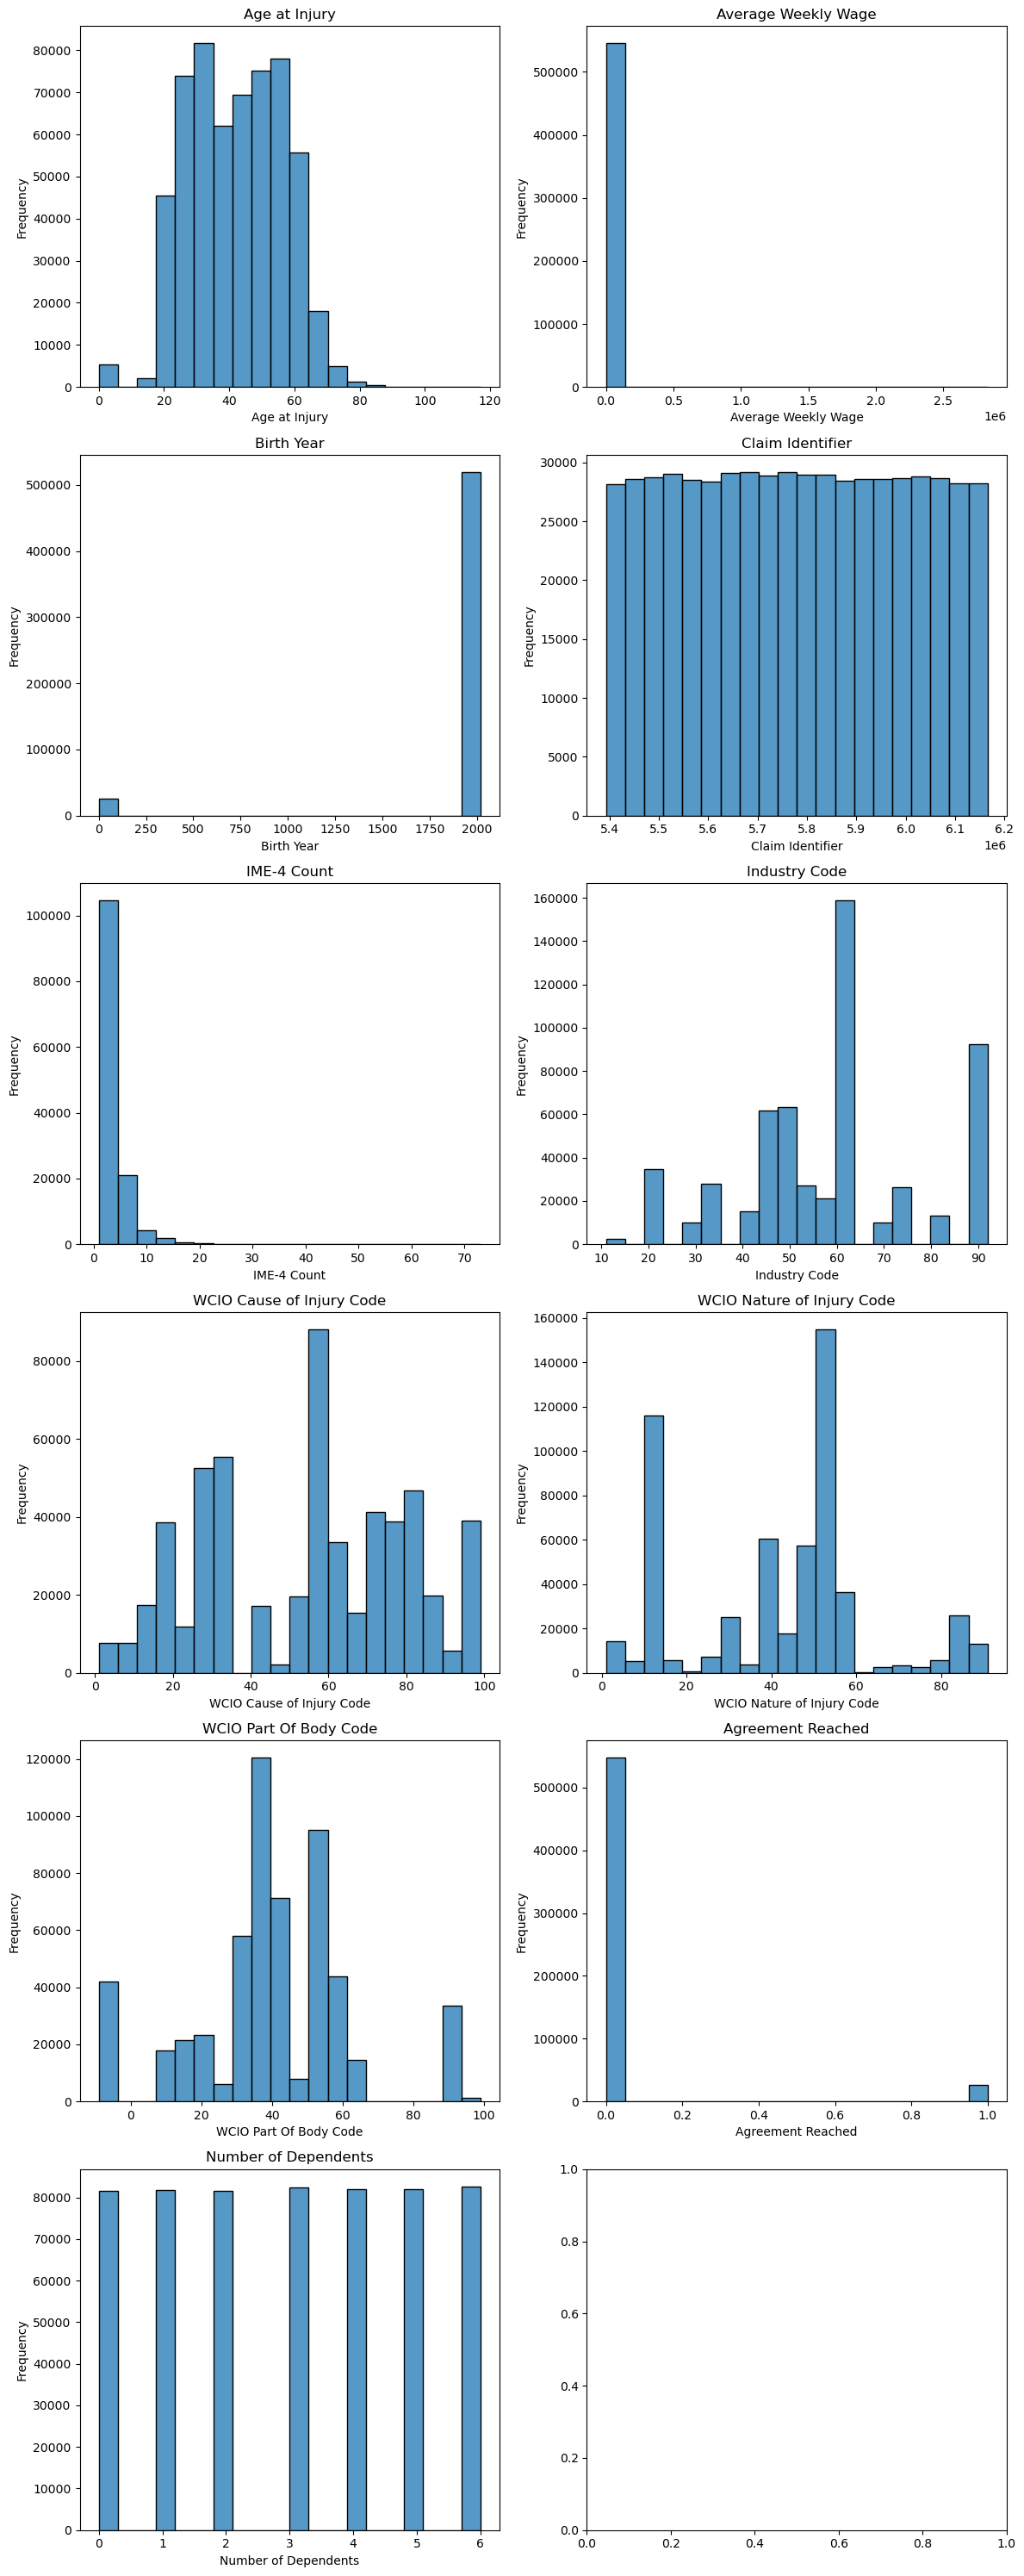

In [14]:
fig, axes = plt.subplots(6, 2, figsize=(12, 30), tight_layout=True)

axes = axes.flatten()

for i, column in enumerate(df_numeric):
    sns.histplot(x=df_numeric[column], bins=20, ax=axes[i])
    axes[i].set_title(f'{column}')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()  
plt.show()

### Age at Injury

In [15]:
df['Age at Injury'].value_counts

<bound method IndexOpsMixin.value_counts of 0         31.0
1         46.0
2         40.0
4         61.0
5         67.0
          ... 
593451    35.0
593455    33.0
593456    61.0
593457    24.0
593467    72.0
Name: Age at Injury, Length: 574026, dtype: float64>

### Alternative Dispute Resolution

In [16]:
df['Alternative Dispute Resolution'].value_counts()

Alternative Dispute Resolution
N    571412
Y      2609
U         5
Name: count, dtype: int64

### New Feature: Days Difference

In [17]:
# Convert the columns to datetime format, if they aren't already
df['Accident Date'] = pd.to_datetime(df['Accident Date'])
df['Assembly Date'] = pd.to_datetime(df['Assembly Date'])

# Calculate the difference in days between the two columns
df['Days Difference'] = (df['Assembly Date'] - df['Accident Date']).dt.days

# DataFrame with the new column
print(df[['Accident Date', 'Assembly Date', 'Days Difference']])

       Accident Date Assembly Date  Days Difference
0         2019-12-30    2020-01-01              2.0
1         2019-08-30    2020-01-01            124.0
2         2019-12-06    2020-01-01             26.0
4         2019-12-30    2020-01-01              2.0
5         2019-12-26    2020-01-01              6.0
...              ...           ...              ...
593451    2022-12-14    2022-12-30             16.0
593455    2022-12-15    2022-12-31             16.0
593456    2022-12-13    2022-12-31             18.0
593457    2022-12-14    2022-12-31             17.0
593467    2022-12-13    2022-12-31             18.0

[574026 rows x 3 columns]


### Attorney/Representative

In [18]:
df['Attorney/Representative'].value_counts()

Attorney/Representative
N    392291
Y    181735
Name: count, dtype: int64

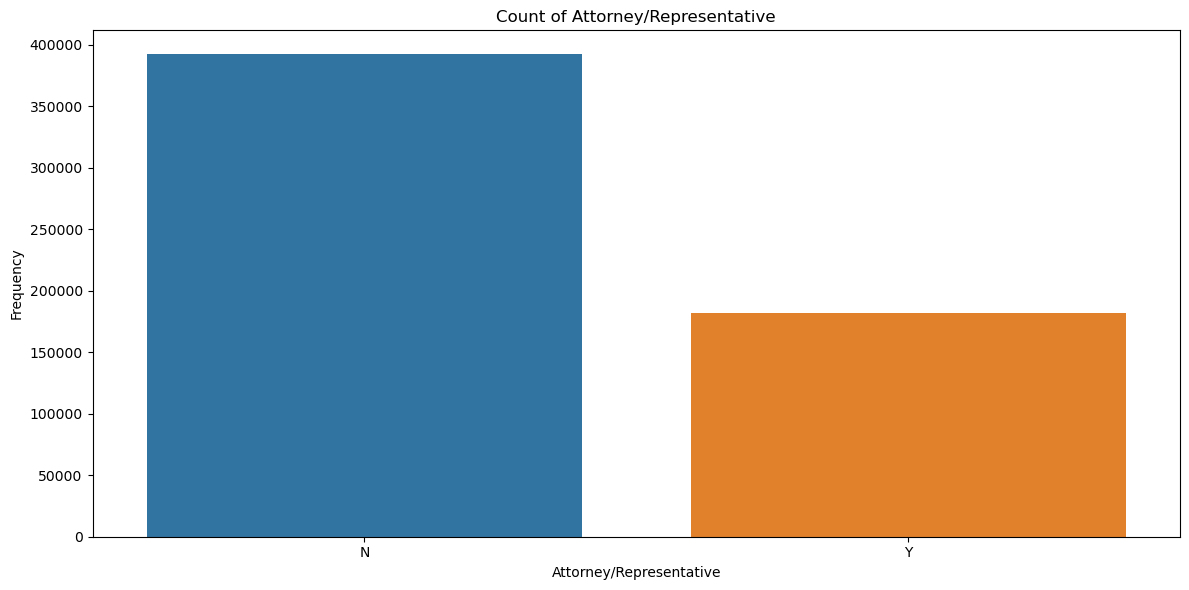

In [19]:
# Assuming df is your DataFrame and 'Attorney/Representative' is a non-numeric column
plt.figure(figsize=(12, 6))  # Setup figure size

# Create a count plot for 'Attorney/Representative'
sns.countplot(x=df['Attorney/Representative'])
plt.title('Count of Attorney/Representative')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Average Weekly Wage

In [20]:
(df['Average Weekly Wage']).value_counts()

Average Weekly Wage
0.00       335450
250.00       3193
600.00       2319
1765.00      1294
500.00       1264
            ...  
1409.93         1
1483.02         1
1885.51         1
2676.03         1
1008.86         1
Name: count, Length: 120024, dtype: int64

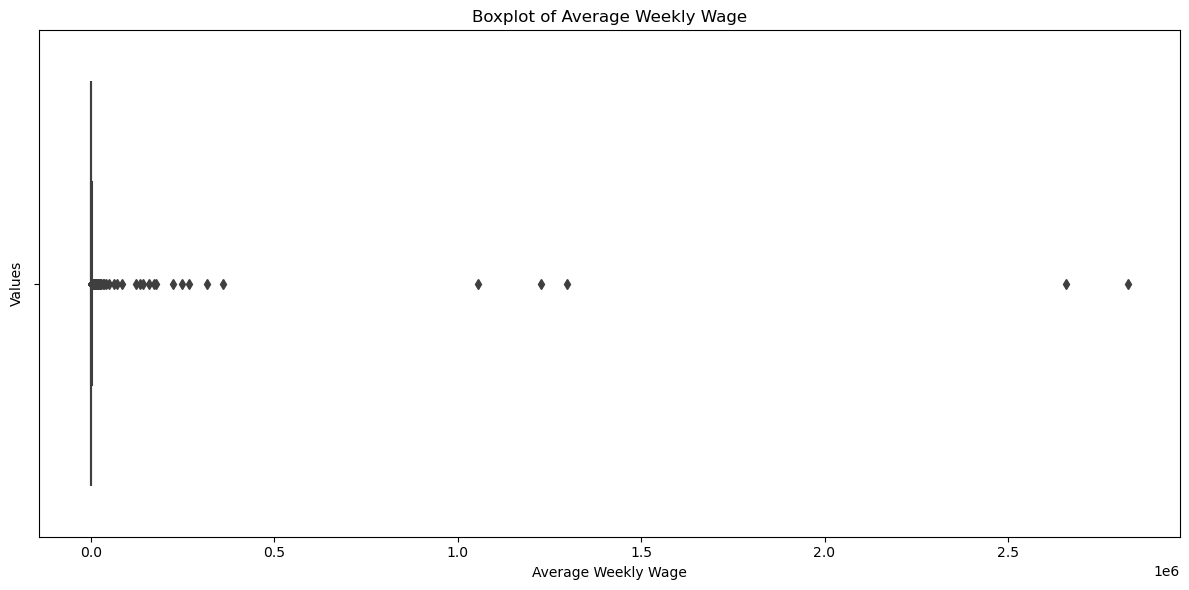

In [21]:
# Assuming df is your DataFrame and 'Average Weekly Wage' is a numeric column
plt.figure(figsize=(12, 6))  # Setup figure size

# Create a boxplot for 'Average Weekly Wage'
sns.boxplot(x=df['Average Weekly Wage'])
plt.title('Boxplot of Average Weekly Wage')
plt.ylabel('Values')

plt.tight_layout()
plt.show()

c:\Users\matil\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


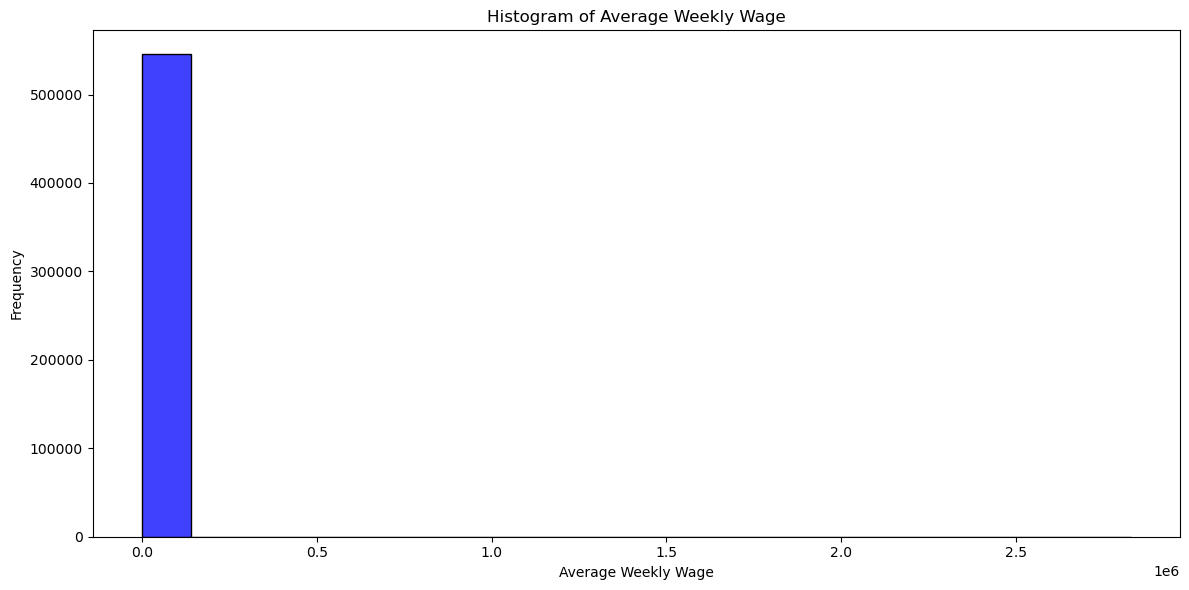

In [22]:
# Assuming df is your DataFrame and 'Average Weekly Wage' is the column of interest
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Create a histogram for the 'Average Weekly Wage'
sns.histplot(df['Average Weekly Wage'].dropna(), bins=20, kde=False, color='blue')
plt.title('Histogram of Average Weekly Wage')
plt.xlabel('Average Weekly Wage')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [23]:
# Calculate value counts including NaN
value_counts = df['Average Weekly Wage'].value_counts(dropna=False)

# Total number of entries
total_entries = df['Average Weekly Wage'].size

# Calculate the percentage of 0.0 values
percent_zero = (value_counts.get(0.0, 0) / total_entries) * 100

# Calculate the percentage of NaN values using np.isnan and sum
percent_nan = (df['Average Weekly Wage'].isna().sum() / total_entries) * 100

# Calculate the percentage of all other values
percent_others = 100 - (percent_zero + percent_nan)

# Print the results
print('Average Weekly Wage Percentages:')
print(f"0.0 values: {percent_zero:.2f}%")
print(f"NaN values: {percent_nan:.2f}%")
print(f"All other values: {percent_others:.2f}%")

Average Weekly Wage Percentages:
0.0 values: 58.44%
NaN values: 4.99%
All other values: 36.57%


### Birth Year

In [24]:
(df['Average Weekly Wage']).value_counts()

Average Weekly Wage
0.00       335450
250.00       3193
600.00       2319
1765.00      1294
500.00       1264
            ...  
1409.93         1
1483.02         1
1885.51         1
2676.03         1
1008.86         1
Name: count, Length: 120024, dtype: int64

In [25]:
(df['Birth Year']==0.0).sum()

25081

c:\Users\matil\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\matil\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


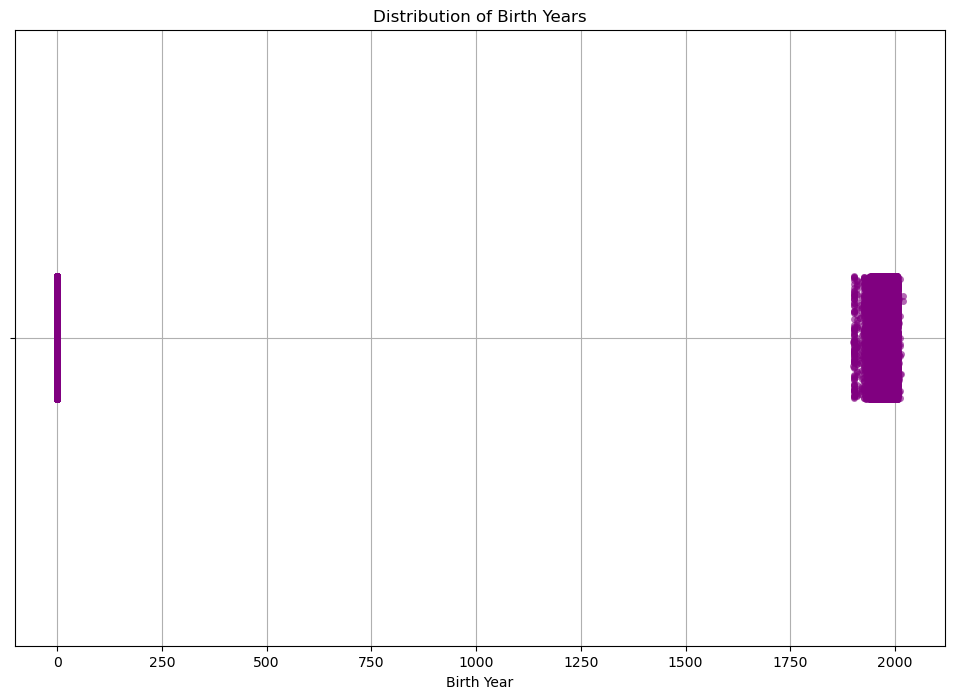

In [26]:
plt.figure(figsize=(12, 8))
sns.stripplot(x=df['Birth Year'], jitter=0.1, size=5, color='purple', alpha=0.6)
plt.title('Distribution of Birth Years')
plt.xlabel('Birth Year')
plt.grid(True)
plt.show()

### Carrier Name

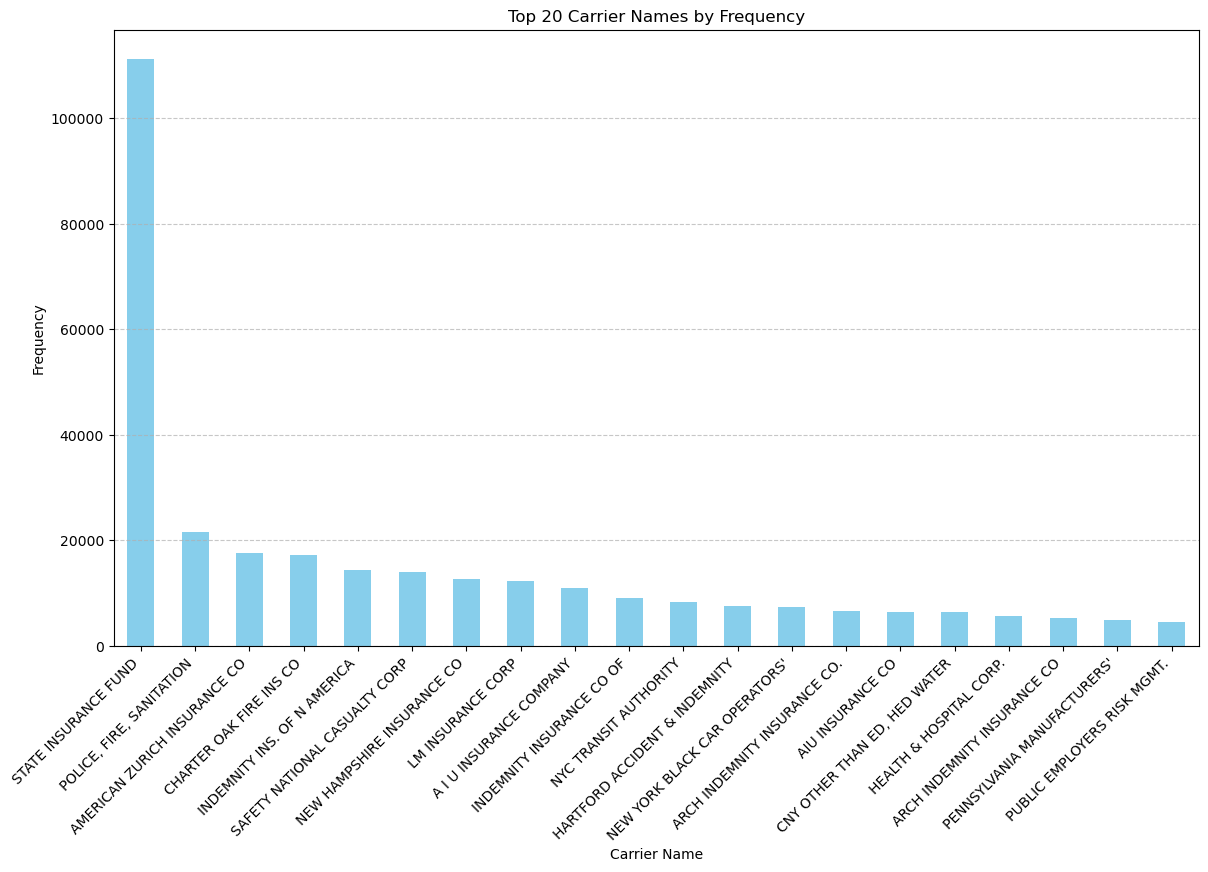

In [27]:
carrier_counts = df['Carrier Name'].value_counts()

plt.figure(figsize=(14, 8))  # Adjust the figure size as necessary
carrier_counts.head(20).plot(kind='bar', color='skyblue')  # Show top 20 carriers for readability
plt.title('Top 20 Carrier Names by Frequency')
plt.xlabel('Carrier Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines for better visual comparison
plt.show()

In [28]:
(df['Carrier Name'] == 'STATE INSURANCE FUND').value_counts(normalize=True) * 100

Carrier Name
False    80.637811
True     19.362189
Name: proportion, dtype: float64

### Claim Injury Type

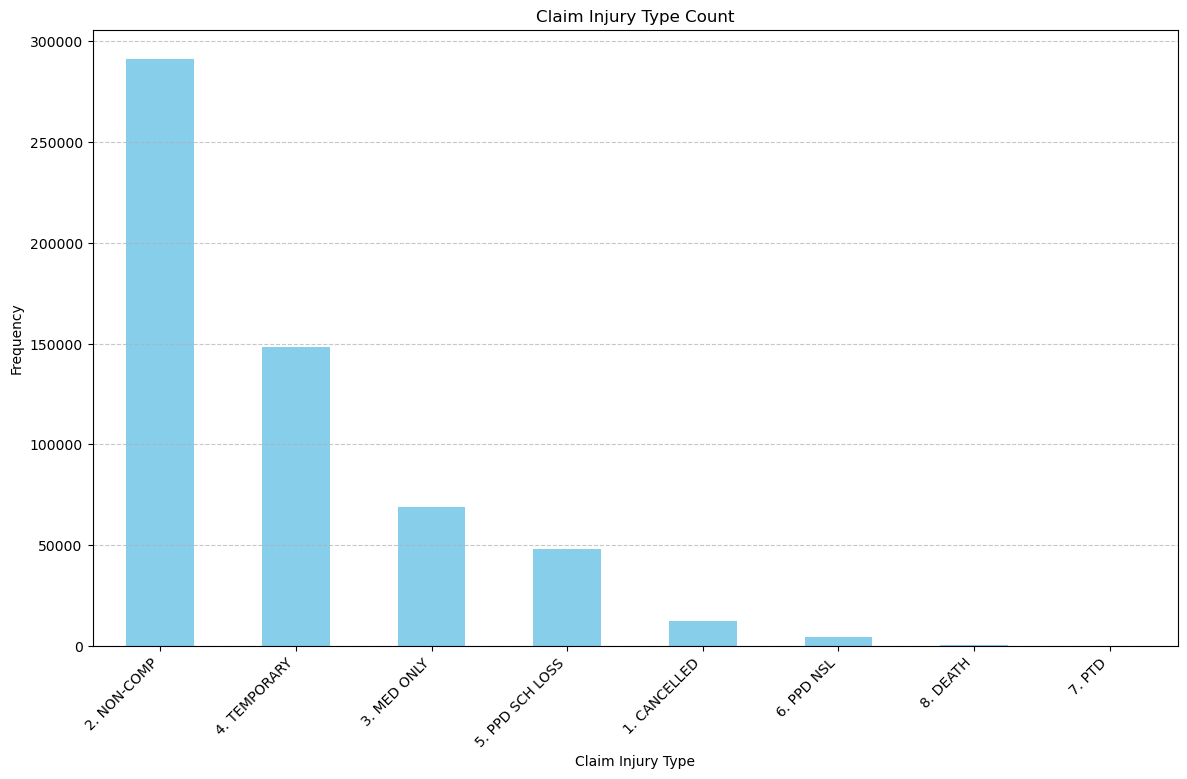

In [29]:
carrier_counts = df['Claim Injury Type'].value_counts()

plt.figure(figsize=(14, 8))  # Adjust the figure size as necessary
carrier_counts.head(20).plot(kind='bar', color='skyblue')  # Show top 20 carriers for readability
plt.title('Claim Injury Type Count')
plt.xlabel('Claim Injury Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines for better visual comparison
plt.show()

### County of Injury

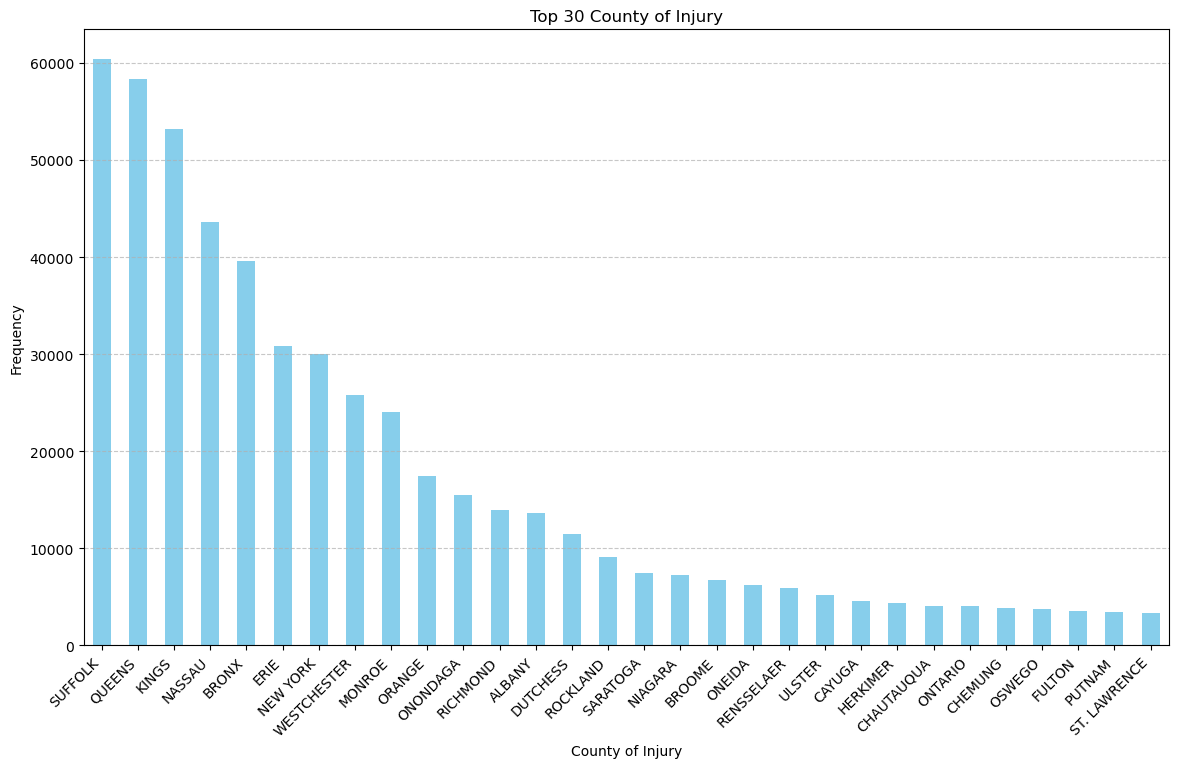

In [30]:
carrier_counts = df['County of Injury'].value_counts()

plt.figure(figsize=(14, 8))  # Adjust the figure size as necessary
carrier_counts.head(30).plot(kind='bar', color='skyblue')  # Show top 20 carriers for readability
plt.title('Top 30 County of Injury')
plt.xlabel('County of Injury')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines for better visual comparison
plt.show()

### COVID-19 Indicator

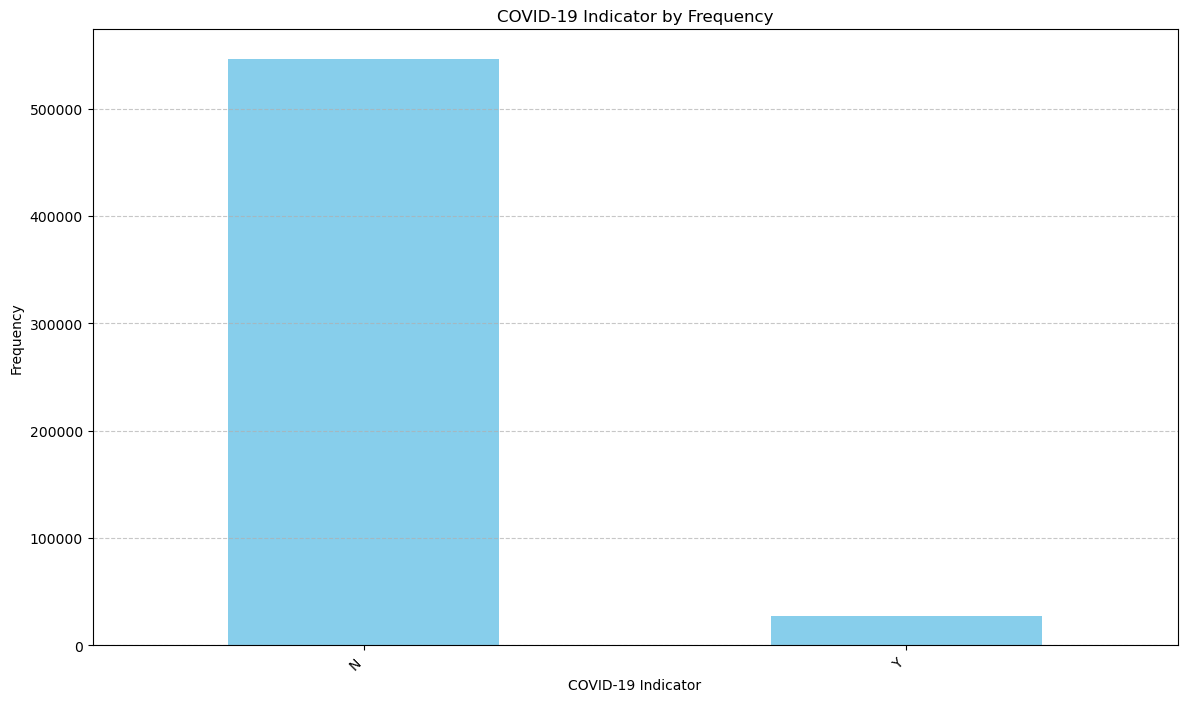

In [31]:
carrier_counts = df['COVID-19 Indicator'].value_counts()

plt.figure(figsize=(14, 8))  # Adjust the figure size as necessary
carrier_counts.head(20).plot(kind='bar', color='skyblue')  # Show top 20 carriers for readability
plt.title('COVID-19 Indicator by Frequency')
plt.xlabel('COVID-19 Indicator')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines for better visual comparison
plt.show()

### District Name

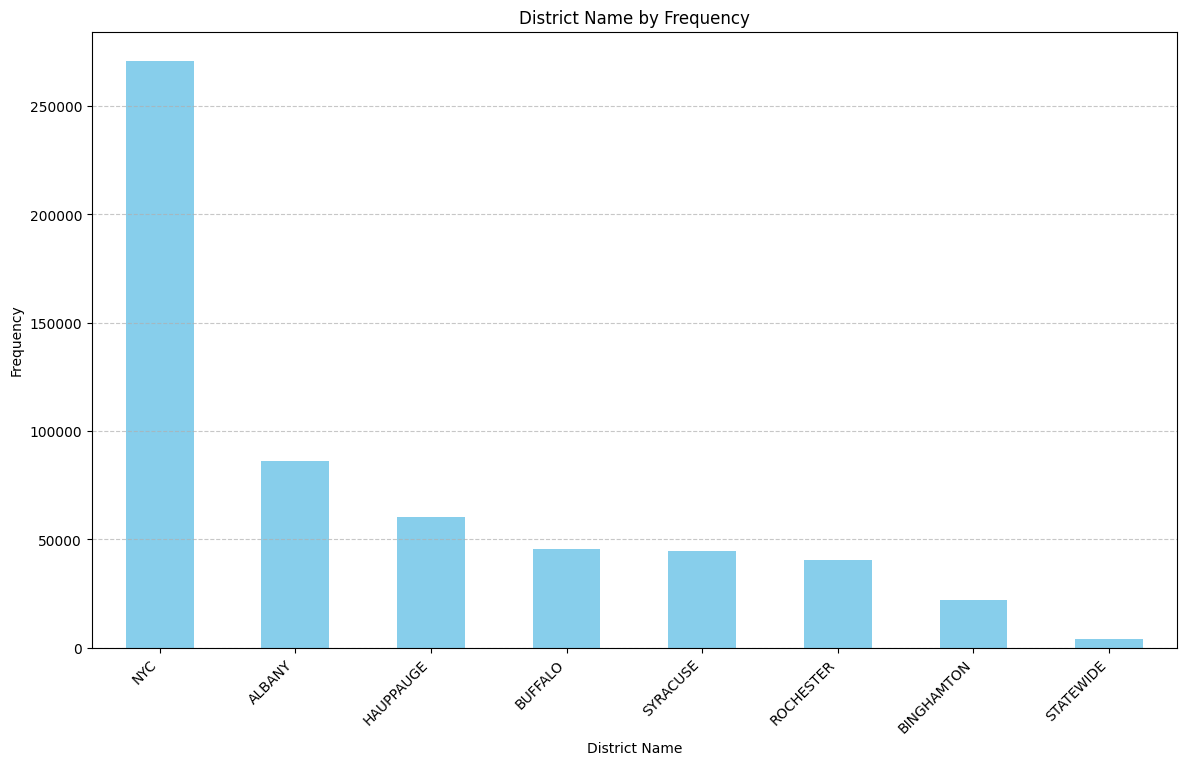

In [187]:
carrier_counts = df['District Name'].value_counts()

plt.figure(figsize=(14, 8))  # Adjust the figure size as necessary
carrier_counts.head(20).plot(kind='bar', color='skyblue')  # Show top 20 carriers for readability
plt.title('District Name by Frequency')
plt.xlabel('District Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines for better visual comparison
plt.show()

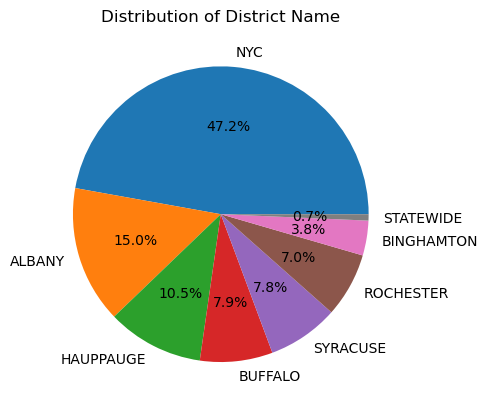

In [32]:
values= df['District Name'].dropna().value_counts()

plt.pie(values, labels=values.index.astype(str), autopct='%1.1f%%')
plt.title('Distribution of District Name')
plt.show()

### Gender

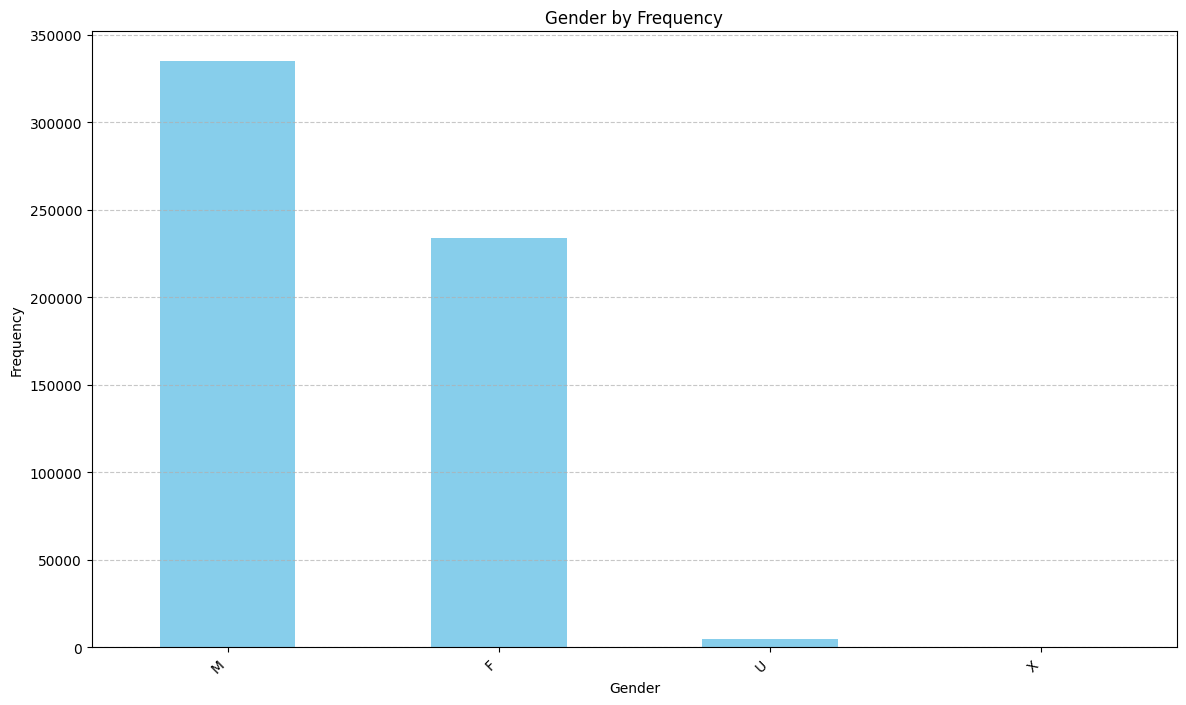

In [189]:
carrier_counts = df['Gender'].value_counts()

plt.figure(figsize=(14, 8))  # Adjust the figure size as necessary
carrier_counts.head(20).plot(kind='bar', color='skyblue')  # Show top 20 carriers for readability
plt.title('Gender by Frequency')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines for better visual comparison
plt.show()

In [33]:
df['Gender'].value_counts()

Gender
M    335218
F    234051
U      4711
X        46
Name: count, dtype: int64

### IME-4 Count Distribution

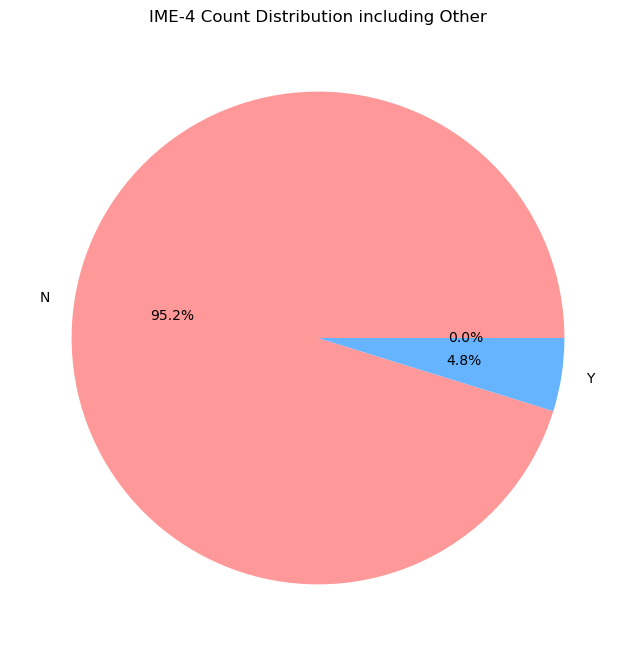

In [34]:

# Assuming 'carrier_counts' contains the value counts of the 'IME-4 Count' column
top_10 = carrier_counts.head(10)
other = carrier_counts.iloc[10:].sum()  # Sum the counts beyond the top 10

# Create a new series that includes 'Other' using pd.concat
pie_data = pd.concat([top_10, pd.Series([other], index=['Other'])])

# Create a pie chart
plt.figure(figsize=(10, 8))
pie_data.plot(kind='pie', autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6', '#c4e17f', '#76d7c4', '#f7c6c7', '#f7b7a3', '#d4e157'])
plt.title('IME-4 Count Distribution including Other')
plt.ylabel('')  # Pie chart does not require a y-label
plt.show()

### Industry Code

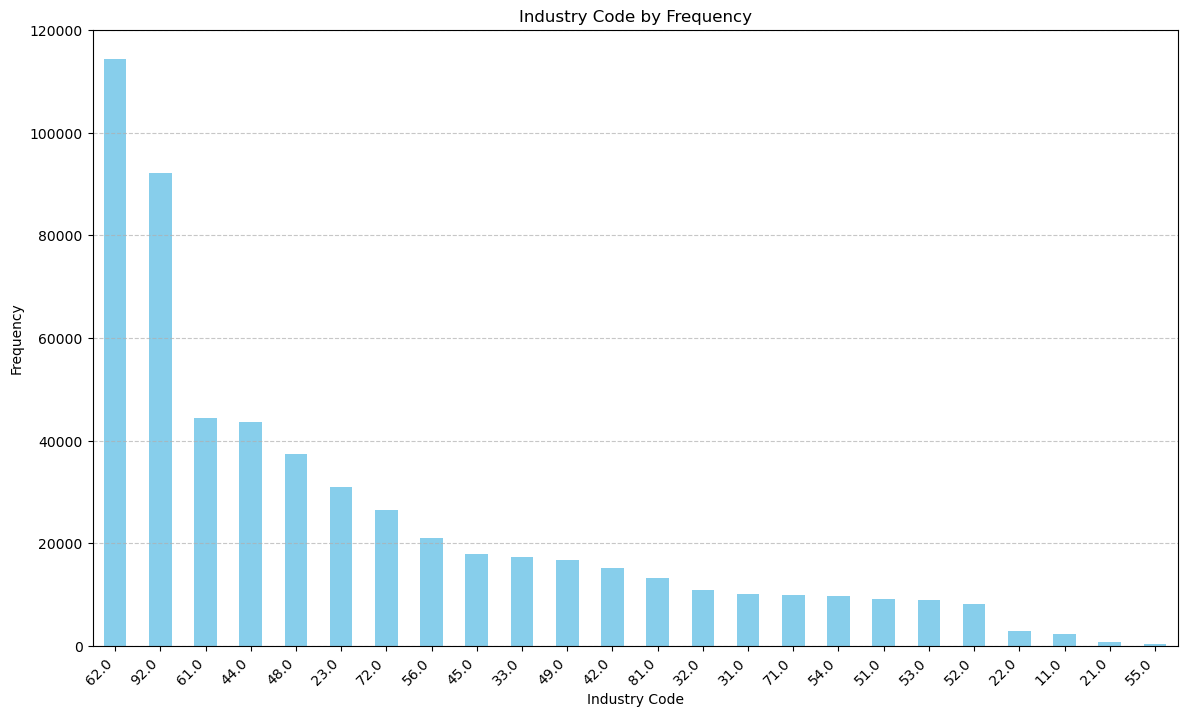

In [35]:
carrier_counts = df['Industry Code'].value_counts()

plt.figure(figsize=(14, 8))  # Adjust the figure size as necessary
carrier_counts.head(24).plot(kind='bar', color='skyblue')  # Show top 20 carriers for readability
plt.title('Industry Code by Frequency')
plt.xlabel('Industry Code')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines for better visual comparison
plt.show()

In [36]:
df['Industry Code'].value_counts()

Industry Code
62.0    114339
92.0     92240
61.0     44393
44.0     43685
48.0     37319
23.0     30903
72.0     26456
56.0     21027
45.0     17953
33.0     17232
49.0     16704
42.0     15236
81.0     13149
32.0     10804
31.0     10114
71.0      9967
54.0      9770
51.0      9166
53.0      8948
52.0      8214
22.0      2980
11.0      2404
21.0       695
55.0       370
Name: count, dtype: int64

### Industry Code Description

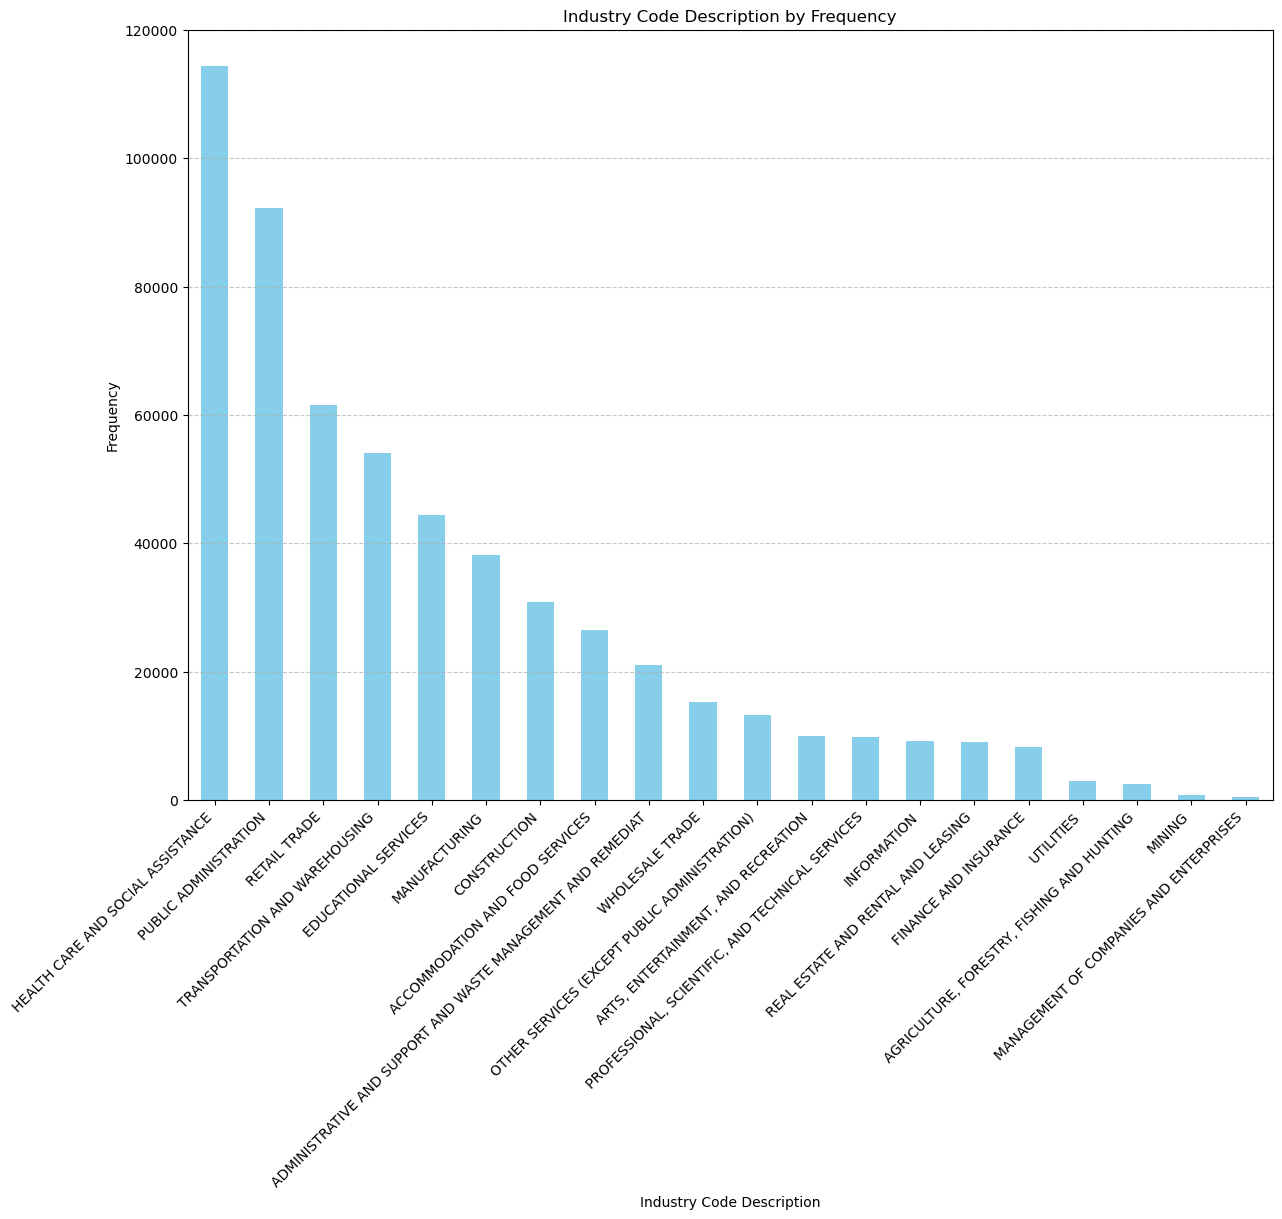

In [37]:
carrier_counts = df['Industry Code Description'].value_counts()

plt.figure(figsize=(14, 10))  # Adjust the figure size as necessary
carrier_counts.head(24).plot(kind='bar', color='skyblue')  # Show top 20 carriers for readability
plt.title('Industry Code Description by Frequency')
plt.xlabel('Industry Code Description')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines for better visual comparison
plt.show()

### Number of Dependents

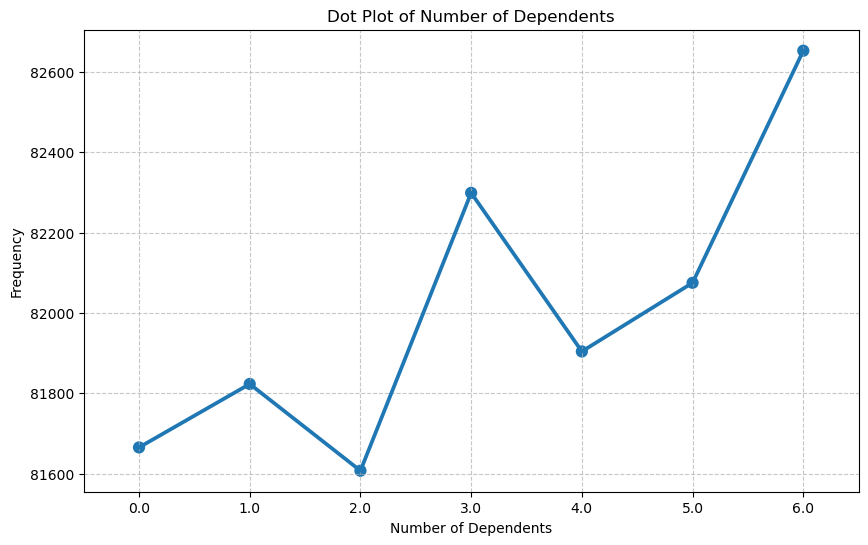

In [38]:
# Count the occurrences of each number of dependents
dependent_counts = df['Number of Dependents'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.pointplot(x=dependent_counts.index, y=dependent_counts.values)
plt.title('Dot Plot of Number of Dependents')
plt.xlabel('Number of Dependents')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

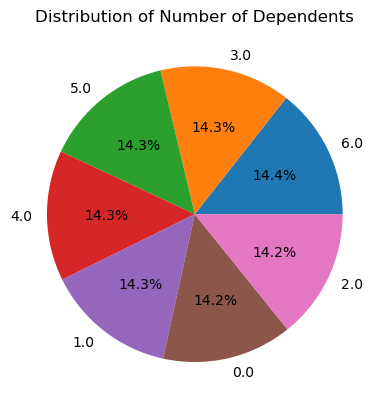

In [39]:
# Drop NA values and count occurrences of each number of dependents
value_counts = df['Number of Dependents'].dropna().value_counts()

# Create a pie chart
plt.pie(value_counts, labels=value_counts.index.astype(str), autopct='%1.1f%%')
plt.title('Distribution of Number of Dependents')
plt.show()

### WCIO Nature of Injury Description

In [42]:
# Filter the data to remove null values in the injury column
filtered_data = df.dropna(subset=['WCIO Nature of Injury Description'])

# Count the 5 most common injuries
top_injuries = filtered_data['WCIO Nature of Injury Description'].value_counts().head(5)

# Display the 5 most common injuries
print(top_injuries)

WCIO Nature of Injury Description
STRAIN OR TEAR                      153373
CONTUSION                           110717
SPRAIN OR TEAR                       55789
LACERATION                           47157
ALL OTHER SPECIFIC INJURIES, NOC     36101
Name: count, dtype: int64


In [43]:
# Replace 'SPRAIN OR TEAR' values with 'STRAIN OR TEAR' (or vice versa, depending on your choice)
filtered_data['WCIO Nature of Injury Description'] = filtered_data['WCIO Nature of Injury Description'].replace('SPRAIN OR TEAR', 'STRAIN OR TEAR')

# Count the 5 most common injuries again after unification
top_injuries_unified = filtered_data['WCIO Nature of Injury Description'].value_counts().head(5)

# Display the results
print(top_injuries_unified)

WCIO Nature of Injury Description
STRAIN OR TEAR                      209162
CONTUSION                           110717
LACERATION                           47157
ALL OTHER SPECIFIC INJURIES, NOC     36101
COVID-19                             25724
Name: count, dtype: int64


C:\Users\matil\AppData\Local\Temp\ipykernel_20508\785499786.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['WCIO Nature of Injury Description'] = filtered_data['WCIO Nature of Injury Description'].replace('SPRAIN OR TEAR', 'STRAIN OR TEAR')


### Relation between WCIO Nature of Injury Description and Industry Code Description

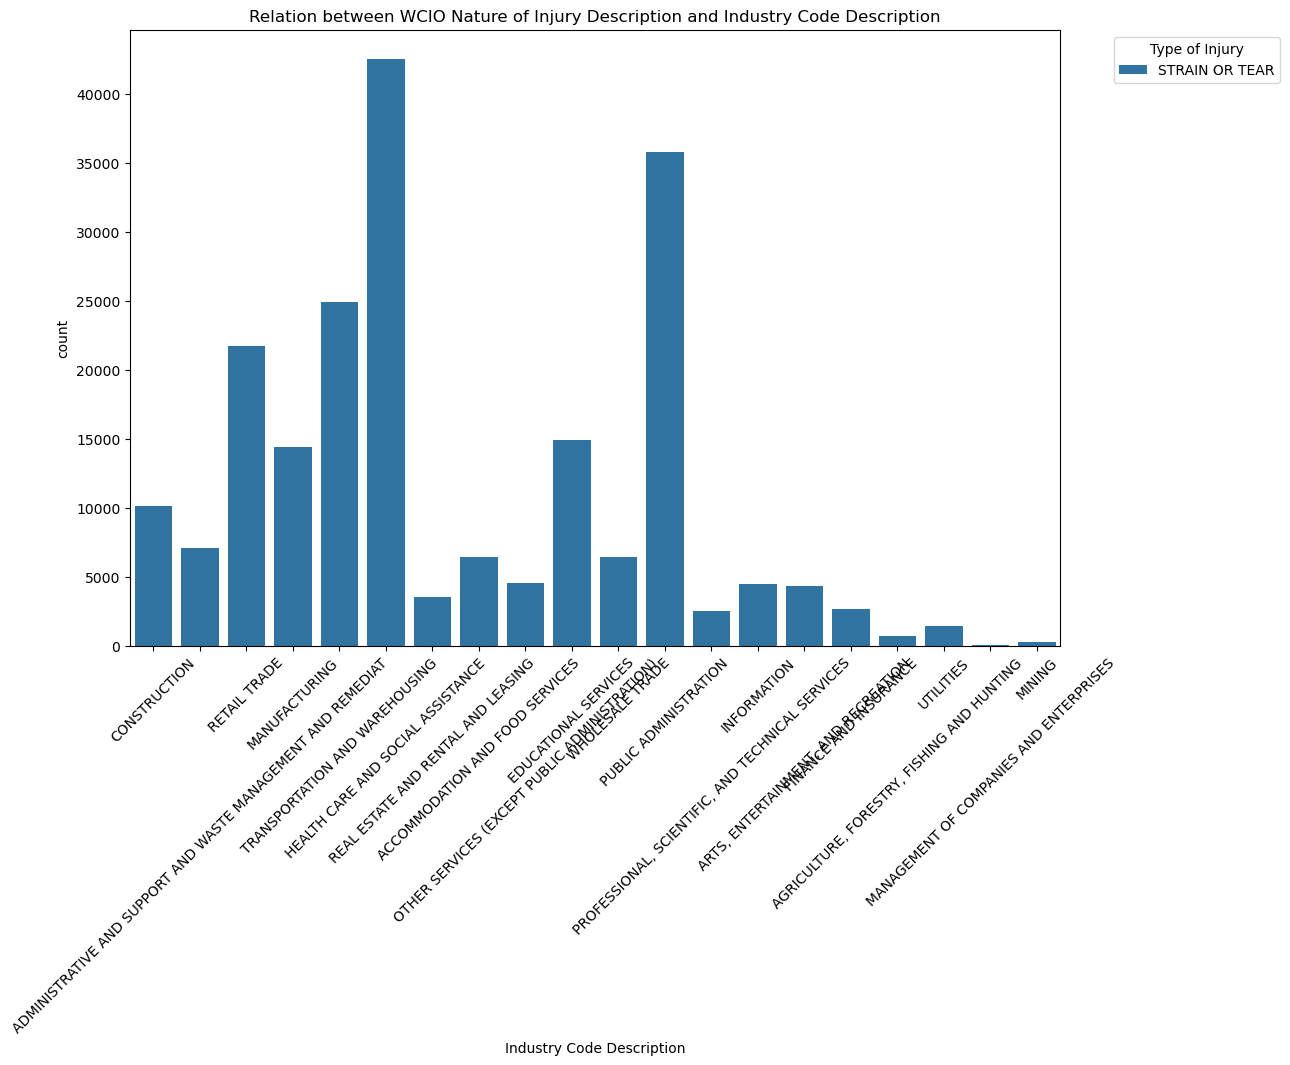

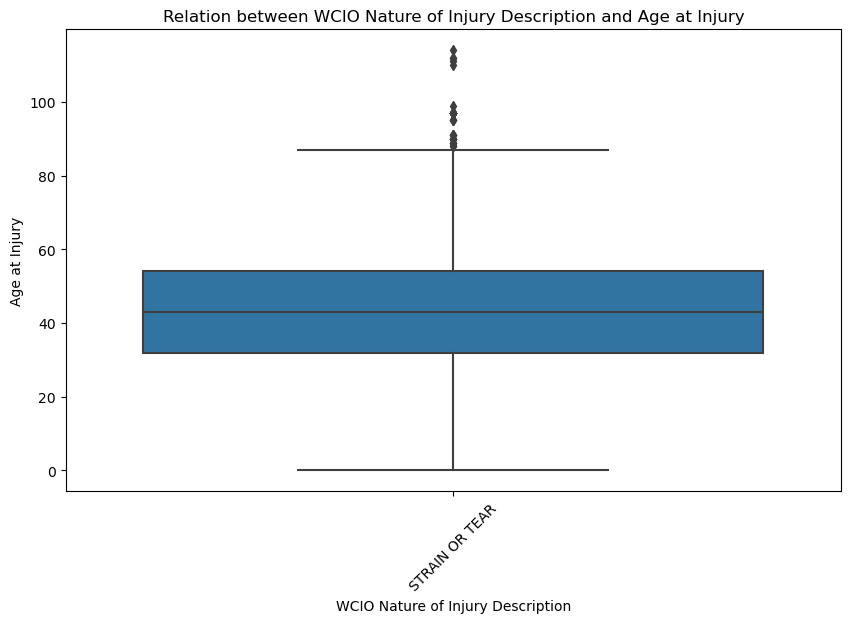

In [44]:
# Define the 5 most common injuries after unification
common_injuries = ['STRAIN OR TEAR']

# Filter the dataset to contain only these injuries
filtered_data = filtered_data[filtered_data['WCIO Nature of Injury Description'].isin(common_injuries)]

# Bar plot to visualize the relationship between injuries and type of work
plt.figure(figsize=(12, 8))
sns.countplot(x='Industry Code Description', hue='WCIO Nature of Injury Description', data=filtered_data)
plt.title('Relation between WCIO Nature of Injury Description and Industry Code Description')
plt.xticks(rotation=45)
plt.legend(title='Type of Injury', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Boxplot to analyze the age of workers by type of injury
plt.figure(figsize=(10, 6))
sns.boxplot(x='WCIO Nature of Injury Description', y='Age at Injury', data=filtered_data)
plt.title('Relation between WCIO Nature of Injury Description and Age at Injury')
plt.xticks(rotation=45)
plt.show()


In [45]:
(df['Alternative Dispute Resolution']).value_counts()

Alternative Dispute Resolution
N    571412
Y      2609
U         5
Name: count, dtype: int64

### Relation between Attorney/Representative and Claim Injury Type

In [46]:
# Filter the data where 'Alternative Dispute Resolution' is 'Y'
adr_yes = df[df['Alternative Dispute Resolution'] == 'Y']

# Count unique values of 'Claim Injury Type' for cases with ADR 'Y'
claim_injury_type_counts_adr_yes = adr_yes['Claim Injury Type'].value_counts()

# Display the results
print("Claim Injury Type when 'Alternative Dispute Resolution' == 'Y'")
print(claim_injury_type_counts_adr_yes)

# Calculate the percentage of each 'Claim Injury Type' when 'Alternative Dispute Resolution' is 'Y'
claim_injury_type_percentage_adr_yes = (claim_injury_type_counts_adr_yes / claim_injury_type_counts_adr_yes.sum()) * 100

# Display the percentages
print(claim_injury_type_percentage_adr_yes)

Claim Injury Type when 'Alternative Dispute Resolution' == 'Y'
Claim Injury Type
2. NON-COMP     2590
1. CANCELLED      19
Name: count, dtype: int64
Claim Injury Type
2. NON-COMP     99.271752
1. CANCELLED     0.728248
Name: count, dtype: float64


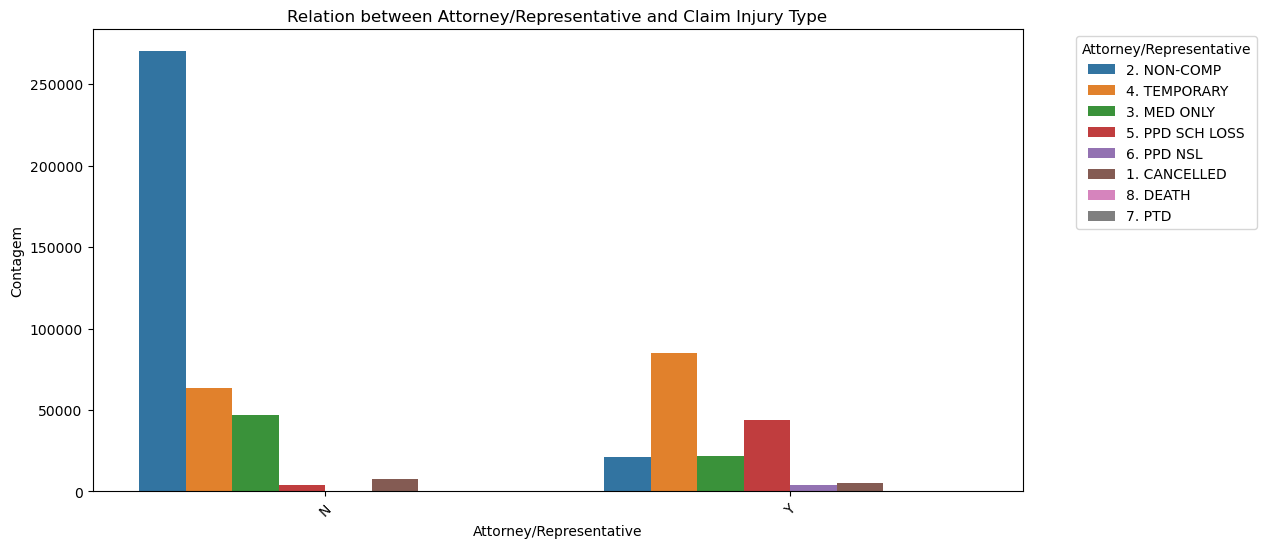

In [47]:
# Create a plot to visualize the relationship between 'Alternative Dispute Resolution' and 'Claim Injury Type'
plt.figure(figsize=(12, 6))
sns.countplot(x='Attorney/Representative', hue='Claim Injury Type', data=df)
plt.title('Relation between Attorney/Representative and Claim Injury Type')
plt.xlabel('Attorney/Representative')
plt.ylabel('Contagem')
plt.legend(title='Attorney/Representative', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

In [48]:
# Create a crosstab to count the frequency of 'Claim Injury Type' based on 'Attorney/Representative'
claim_injury_type_by_attorney = pd.crosstab(df['Claim Injury Type'], df['Attorney/Representative'])

# Calculate the percentage of each value in total for attorney and non-attorney
claim_injury_type_percentage = claim_injury_type_by_attorney.apply(lambda x: x / x.sum() * 100, axis=1)

# Concatenate the absolute values with the percentages
claim_injury_type_with_percentage = pd.concat([claim_injury_type_by_attorney, claim_injury_type_percentage], axis=1, keys=['Count', 'Percentage'])

# Display the result
print(claim_injury_type_with_percentage)

                          Count        Percentage           
Attorney/Representative       N      Y          N          Y
Claim Injury Type                                           
1. CANCELLED               7426   5051  59.517512  40.482488
2. NON-COMP              269969  21109  92.747992   7.252008
3. MED ONLY               47207  21699  68.509274  31.490726
4. TEMPORARY              63268  85239  42.602706  57.397294
5. PPD SCH LOSS            4279  44001   8.862883  91.137117
6. PPD NSL                   89   4122   2.113512  97.886488
7. PTD                        1     96   1.030928  98.969072
8. DEATH                     52    418  11.063830  88.936170


### Average Weekly Wage by Attorney/Representative

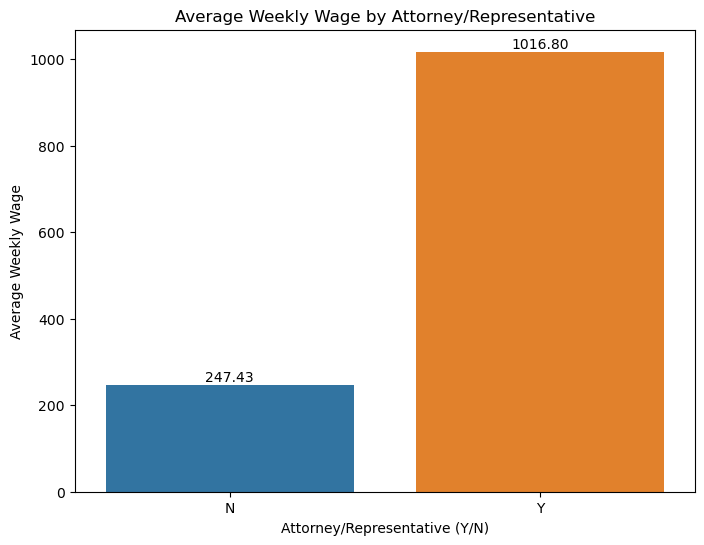

In [50]:
# Calculate the mean 'Average Weekly Wage' for each 'Attorney/Representative' category
mean_wage_by_lawyer = df.groupby('Attorney/Representative')['Average Weekly Wage'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x='Attorney/Representative', y='Average Weekly Wage', data=mean_wage_by_lawyer)

# Add title and labels
plt.title('Average Weekly Wage by Attorney/Representative')
plt.xlabel('Attorney/Representative (Y/N)')
plt.ylabel('Average Weekly Wage')

# Annotate the bar plot with the actual mean values
for index, row in mean_wage_by_lawyer.iterrows():
    bar_plot.text(index, row['Average Weekly Wage'], f"{row['Average Weekly Wage']:.2f}", 
                  color='black', ha="center", va="bottom")

# Show the plot
plt.show()

### Relation between Carrier Type and Claim Injury Type

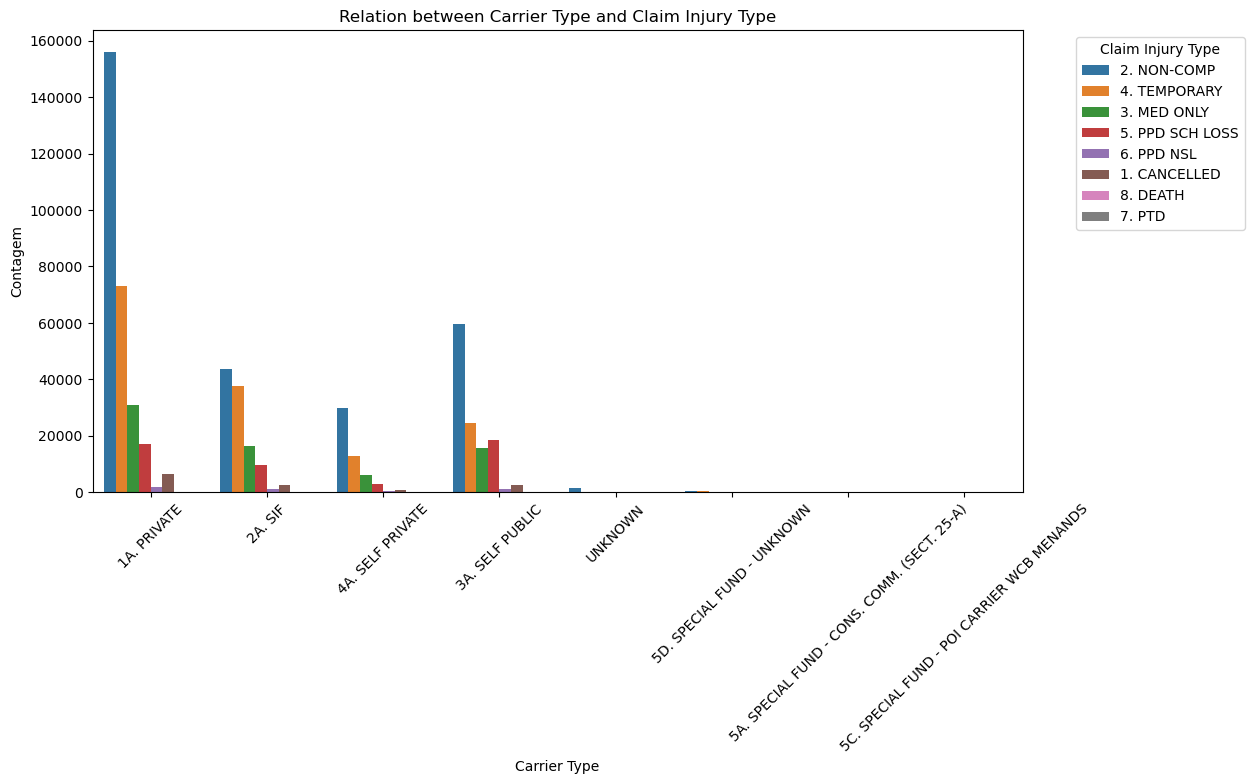

In [51]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Carrier Type', hue='Claim Injury Type', data=df)
plt.title('Relation between Carrier Type and Claim Injury Type')
plt.xlabel('Carrier Type')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
plt.legend(title='Claim Injury Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

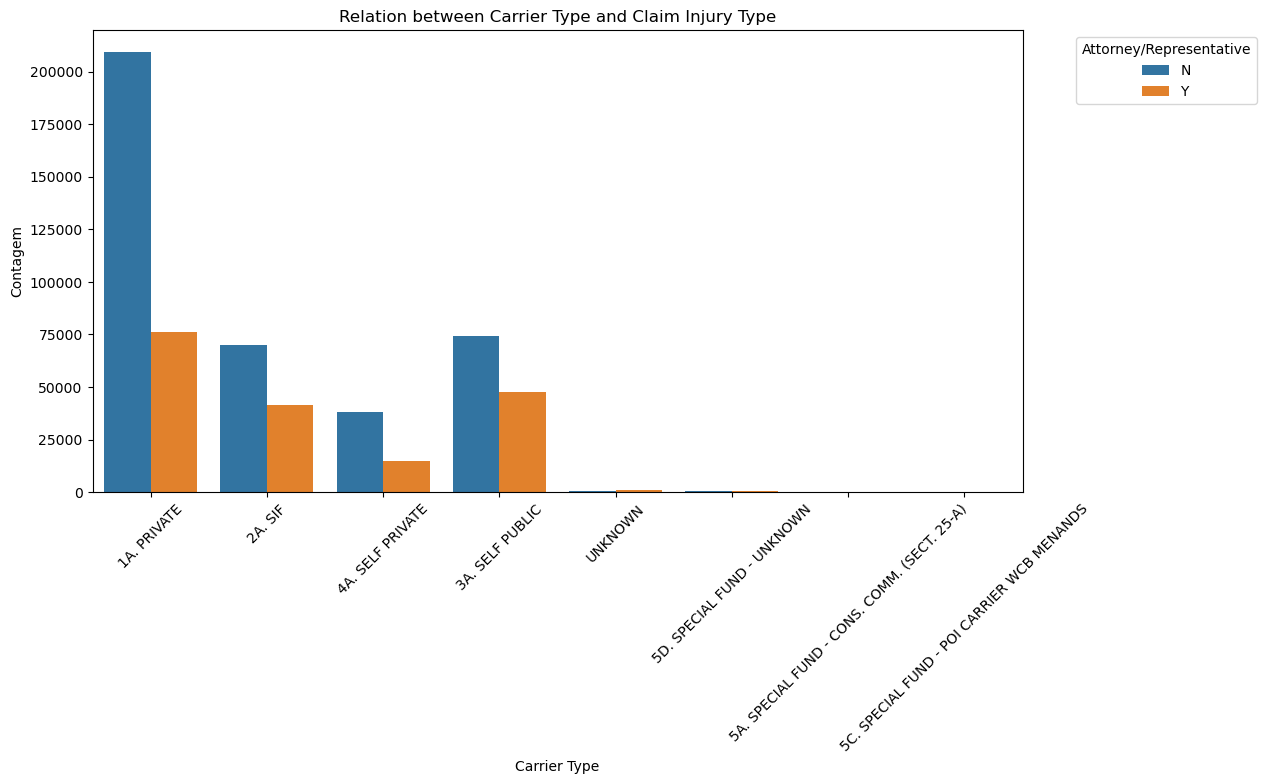

In [52]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Carrier Type', hue='Attorney/Representative', data=df)
plt.title('Relation between Carrier Type and Claim Injury Type')
plt.xlabel('Carrier Type')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
plt.legend(title='Attorney/Representative', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [54]:
# Create a crosstab to count the frequency of 'Carrier Type' based on 'Attorney/Representative'
carrier_type_with_attorney_counts = pd.crosstab(df['Carrier Type'], df['Attorney/Representative'])

# Display the results
print(carrier_type_with_attorney_counts)

Attorney/Representative                           N      Y
Carrier Type                                              
1A. PRIVATE                                  209231  76137
2A. SIF                                       69835  41309
3A. SELF PUBLIC                               74180  47740
4A. SELF PRIVATE                              37996  14792
5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)       3      1
5C. SPECIAL FUND - POI CARRIER WCB MENANDS        2      3
5D. SPECIAL FUND - UNKNOWN                      349    674
UNKNOWN                                         695   1079


### Relation between COVID-19 Indicator and Claim Injury Type

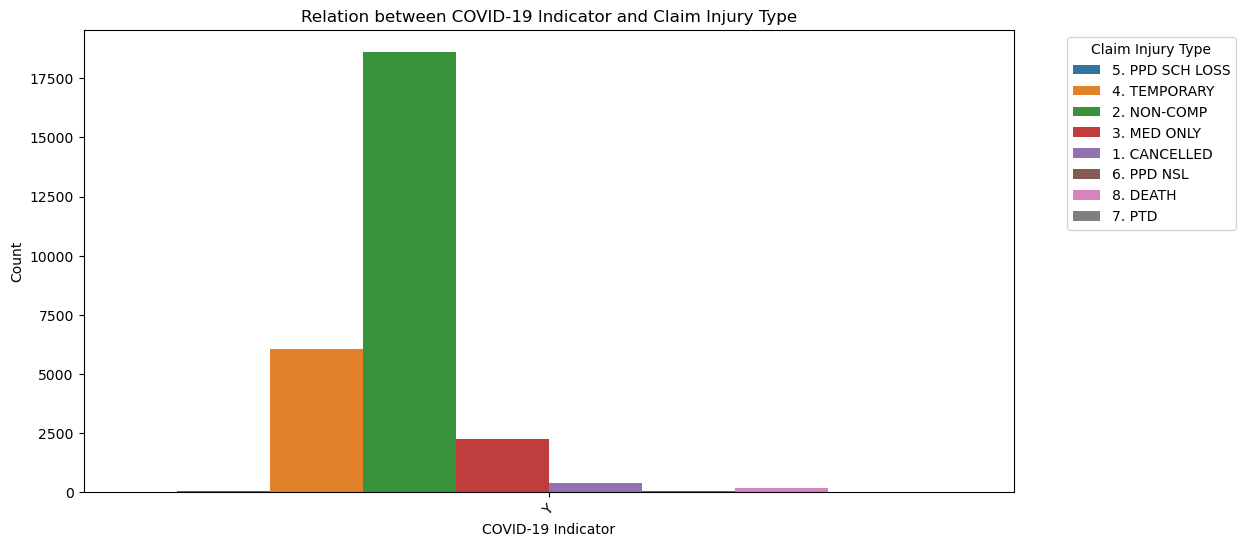

In [55]:
covid_yes = df[df['COVID-19 Indicator'] == 'Y']

plt.figure(figsize=(12, 6))
sns.countplot(x='COVID-19 Indicator', hue='Claim Injury Type', data=covid_yes)
plt.title('Relation between COVID-19 Indicator and Claim Injury Type')
plt.xlabel('COVID-19 Indicator')
plt.ylabel('Count')
plt.legend(title='Claim Injury Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

In [56]:
# Filter the data where 'COVID-19 Indicator' is 'Y'
covid_yes = df[df['COVID-19 Indicator'] == 'Y']

# Count the number of occurrences of 'Claim Injury Type' for cases where 'COVID-19 Indicator' = 'Y'
covid_yes_claim_injury_counts = covid_yes['Claim Injury Type'].value_counts()

# Calculate the percentage of each injury type
total_claims = covid_yes_claim_injury_counts.sum()
covid_yes_claim_injury_percentage = (covid_yes_claim_injury_counts / total_claims) * 100

# Calculate the cumulative percentage
covid_yes_claim_injury_cumulative_percentage = covid_yes_claim_injury_percentage.cumsum()

# Create a DataFrame with counts, percentages, and cumulative percentage
covid_yes_claim_injury_df = pd.DataFrame({
    'Count': covid_yes_claim_injury_counts,
    'Percentage': covid_yes_claim_injury_percentage,
    'Cumulative Percentage': covid_yes_claim_injury_cumulative_percentage
})

# Display the result
print("Claim Injury Type for cases where COVID-19 Indicator = 'Y'")
print(covid_yes_claim_injury_df)



Claim Injury Type for cases where COVID-19 Indicator = 'Y'
                   Count  Percentage  Cumulative Percentage
Claim Injury Type                                          
2. NON-COMP        18621   67.661059              67.661059
4. TEMPORARY        6048   21.975946              89.637004
3. MED ONLY         2233    8.113804              97.750808
1. CANCELLED         391    1.420733              99.171542
8. DEATH             166    0.603176              99.774717
6. PPD NSL            32    0.116275              99.890992
5. PPD SCH LOSS       17    0.061771              99.952763
7. PTD                13    0.047237             100.000000


### Relation betweenAge at Injury and Mean IME-4 Count

c:\Users\matil\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\matil\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


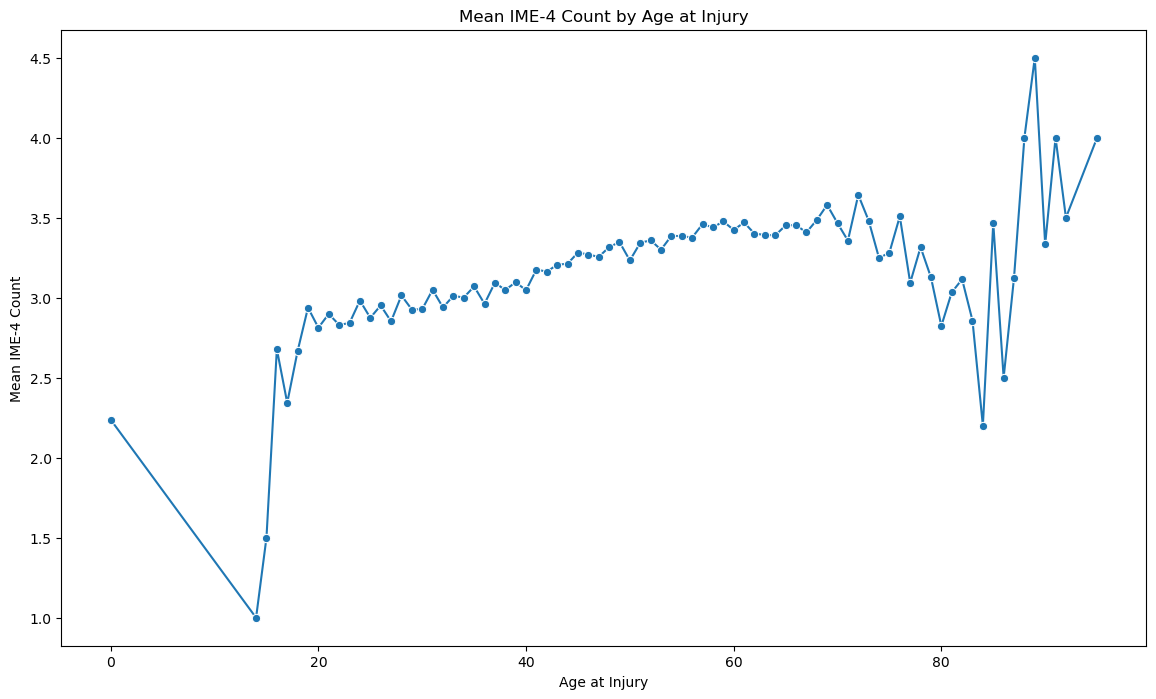

In [57]:
# Create a line plot
mean_ime_by_age = df.groupby('Age at Injury')['IME-4 Count'].mean().reset_index()

plt.figure(figsize=(14, 8))
sns.lineplot(x='Age at Injury', y='IME-4 Count', data=mean_ime_by_age, marker='o')

# Add title and labels
plt.title('Mean IME-4 Count by Age at Injury')
plt.xlabel('Age at Injury')
plt.ylabel('Mean IME-4 Count')

# Show the plot
plt.show()

### Relation between Average Weekly Wage and Attorney/Representative

  Attorney/Representative  Average Weekly Wage
0                       N          1197.049809
1                       Y          1321.481600


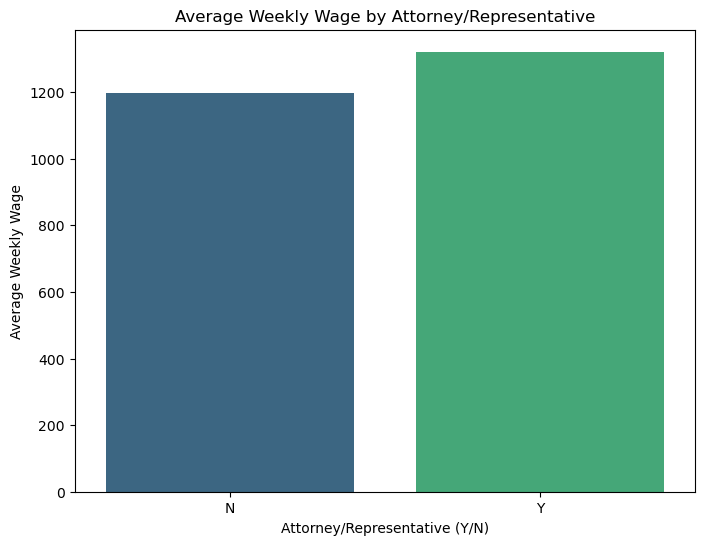

In [58]:
# Remove rows where 'Average Weekly Wage' is 0.0 or NaN
filtered_df = df[df['Average Weekly Wage'] > 0]

# Ensure that the column names match exactly the ones in your dataset.
# Group by 'Attorney/Representative' and calculate the mean 'Average Weekly Wage'
mean_wage_by_lawyer = filtered_df.groupby('Attorney/Representative')['Average Weekly Wage'].mean().reset_index()

print(mean_wage_by_lawyer)

plt.figure(figsize=(8, 6))
sns.barplot(x='Attorney/Representative', y='Average Weekly Wage', data=mean_wage_by_lawyer, palette='viridis')

# Add title and labels
plt.title('Average Weekly Wage by Attorney/Representative')
plt.xlabel('Attorney/Representative (Y/N)')
plt.ylabel('Average Weekly Wage')

# Show the plot
plt.show()

### Relation between Mean Average Weekly Wage and Age at Injury

c:\Users\matil\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\matil\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


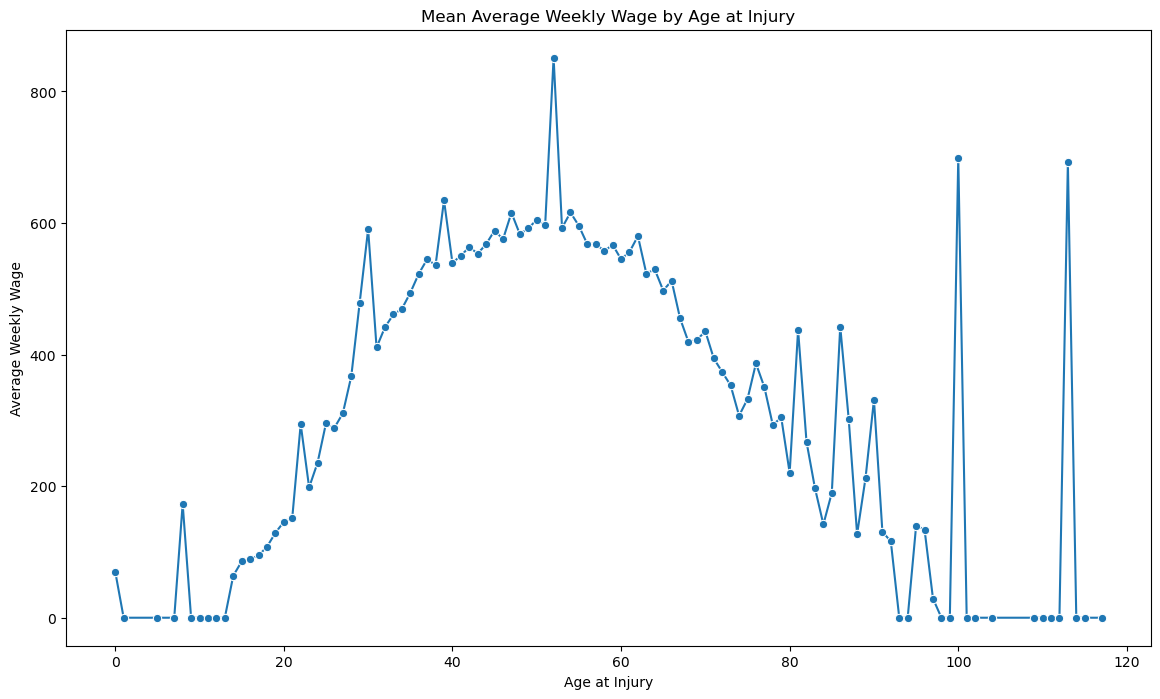

In [59]:
# Create a line plot
mean_wage_by_age = df.groupby('Age at Injury')['Average Weekly Wage'].mean().reset_index()

plt.figure(figsize=(14, 8))
sns.lineplot(x='Age at Injury', y='Average Weekly Wage', data=mean_wage_by_age, marker='o')

# Add title and labels
plt.title('Mean Average Weekly Wage by Age at Injury')
plt.xlabel('Age at Injury')
plt.ylabel('Average Weekly Wage')

# Show the plot
plt.show()

### Relation between Mean Days Difference and Age at Injury

c:\Users\matil\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\matil\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


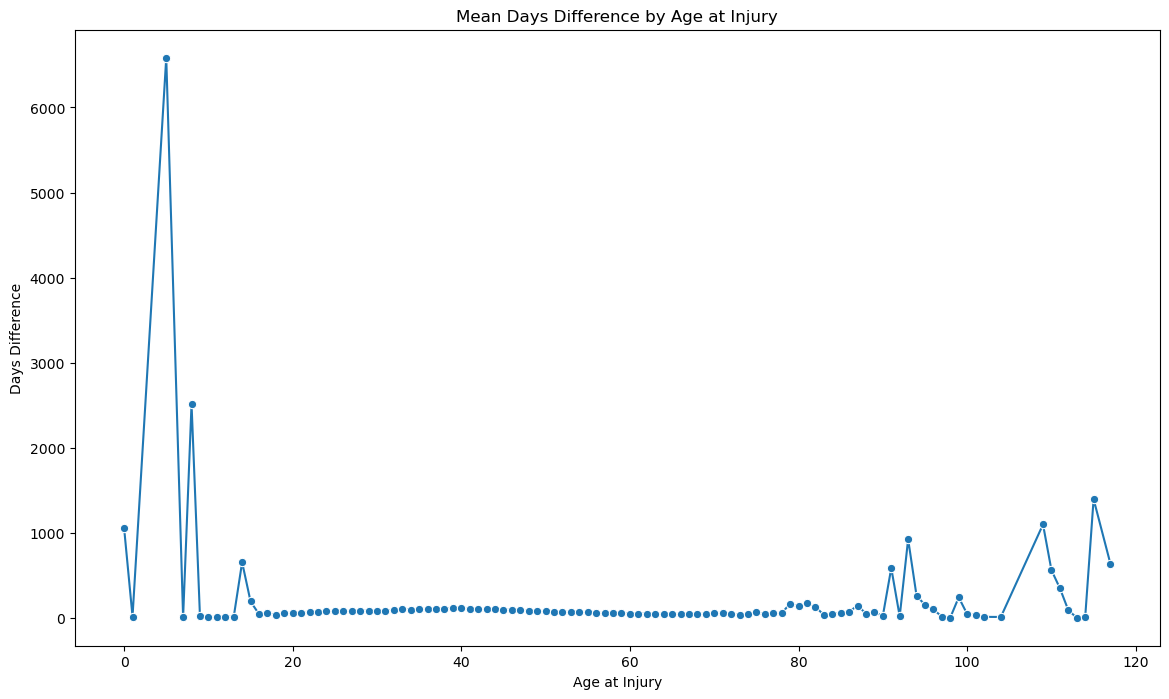

In [60]:
# Create a line plot
mean_daysdif_by_age = df.groupby('Age at Injury')['Days Difference'].mean().reset_index()

plt.figure(figsize=(14, 8))
sns.lineplot(x='Age at Injury', y='Days Difference', data=mean_daysdif_by_age, marker='o')

# Add title and labels
plt.title('Mean Days Difference by Age at Injury')
plt.xlabel('Age at Injury')
plt.ylabel('Days Difference')

# Show the plot
plt.show()

### Relation between Mean Days Difference and Average Weekly Wage

c:\Users\matil\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\matil\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


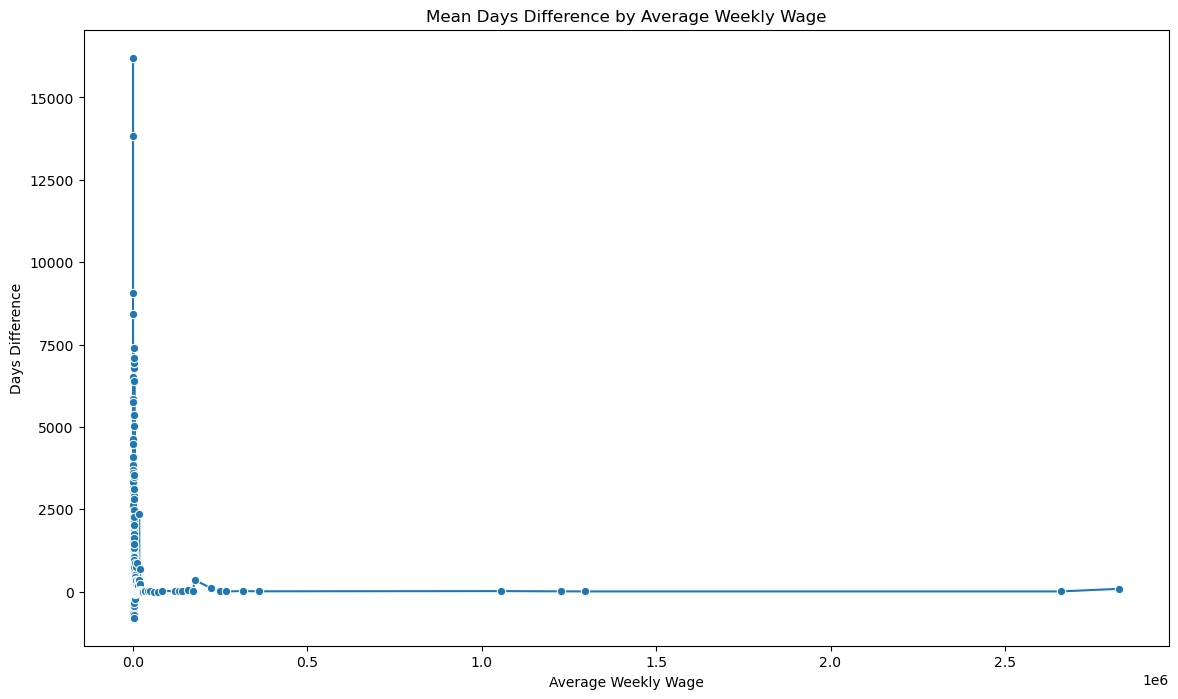

In [61]:
# Create a line plot
mean_daysdif_by_wage = df.groupby('Average Weekly Wage')['Days Difference'].mean().reset_index()

plt.figure(figsize=(14, 8))
sns.lineplot(x='Average Weekly Wage', y='Days Difference', data=mean_daysdif_by_wage, marker='o')

# Add title and labels
plt.title('Mean Days Difference by Average Weekly Wage')
plt.xlabel('Average Weekly Wage')
plt.ylabel('Days Difference')

# Show the plot
plt.show()

### Relation between Mean Days Difference and District

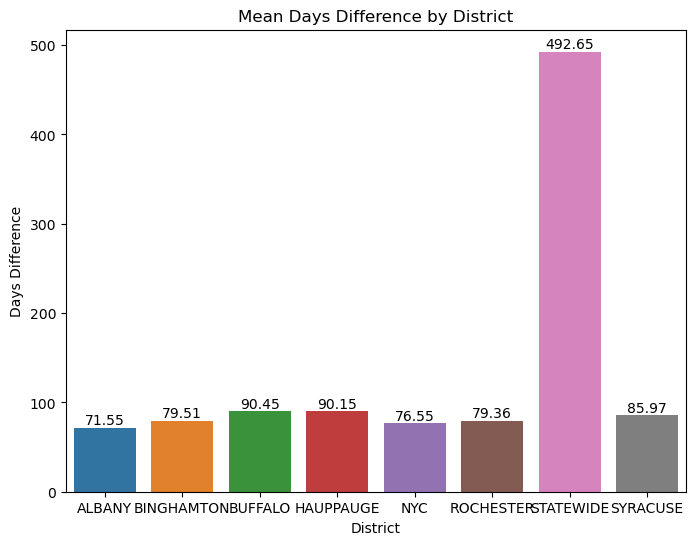

In [62]:
mean_daysdif_by_district = df.groupby('District Name')['Days Difference'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x='District Name', y='Days Difference', data=mean_daysdif_by_district)

# Add title and labels
plt.title('Mean Days Difference by District')
plt.xlabel('District')
plt.ylabel('Days Difference')

# Annotate the bar plot with the actual mean values
for index, row in mean_daysdif_by_district.iterrows():
    bar_plot.text(index, row['Days Difference'], f"{row['Days Difference']:.2f}", 
                  color='black', ha="center", va="bottom")

# Show the plot
plt.show()

### Proportion between Atorney/Representative within District Name

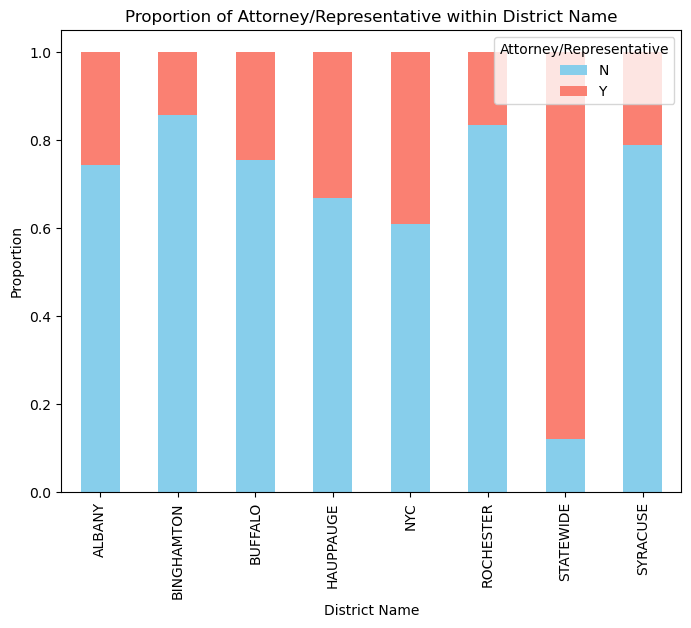

In [63]:
# Create a crosstab to show the proportion of 'Attorney/Representative' within each 'District Name'
cross_tab = pd.crosstab(df['District Name'], df['Attorney/Representative'], normalize='index')

# Plot the stacked bar chart with proportions
cross_tab.plot(kind='bar', stacked=True, figsize=(8, 6), color=['skyblue', 'salmon'])

# Add labels and title
plt.title('Proportion of Attorney/Representative within District Name')
plt.xlabel('District Name')
plt.ylabel('Proportion')
plt.legend(title='Attorney/Representative', loc='upper right')
plt.show()

### Mean Days Difference by Attorney/Representative

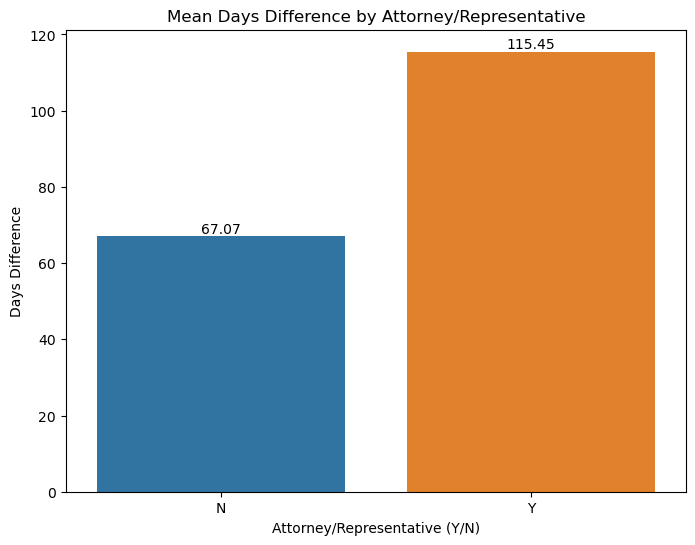

In [64]:
mean_daysdif_by_lawyer = df.groupby('Attorney/Representative')['Days Difference'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x='Attorney/Representative', y='Days Difference', data=mean_daysdif_by_lawyer)

# Add title and labels
plt.title('Mean Days Difference by Attorney/Representative')
plt.xlabel('Attorney/Representative (Y/N)')
plt.ylabel('Days Difference')

# Annotate the bar plot with the actual mean values
for index, row in mean_daysdif_by_lawyer.iterrows():
    bar_plot.text(index, row['Days Difference'], f"{row['Days Difference']:.2f}", 
                  color='black', ha="center", va="bottom")

# Show the plot
plt.show()